# Comparing loforest to other methods

In [1]:
import numpy as np
import pandas as pd
import os
import scipy.stats as st

from nonconformist.cp import IcpRegressor
from nonconformist.nc import NcFactory
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

from clover.locart import LocalRegressionSplit, LocartSplit, MondrianRegressionSplit, QuantileSplit
from clover.scores import RegressionScore, QuantileScore, LocalRegressionScore
import time
from clover.simulation import simulation
from clover.utils import compute_interval_length, split, real_coverage, smis
from clover.locart import RegressionSplit

from CP2LFI.loforest import ConformalLoforest
from tqdm import tqdm

# packages to create CNN
import torch
import torch.nn.functional as F
from torch import nn
from torch import optim
from torch.utils.data import TensorDataset, DataLoader

original_path = os.getcwd()

# figure path
images_dir = "figures"

## Simulated settings

In [2]:
def obtain_main_metrics_sim(
    n = 25000,
    kind = "homoscedastic",
    figname_tree = "tree",
    d = 20,
    hetero_value = 1,
    asym_value = 0.6,
    t_degree = 4,
    base_model = RandomForestRegressor,
    neural_network = False,
    sig = 0.1, 
    test_size = 0.2,
    calib_size = 0.5, 
    coef = 2,
    noise = True,
    signif_vars = 5,
    B_x = 5000,
    B_y = 1000, 
    random_seed_X = 850,
    random_seed = 1250,
    split_calib = False,
    plot_tree = False,
    nbins = 30,
    criterion = "squared_error",
    is_fitted = True,
    max_depth = None,
    max_leaf_nodes = None,
    min_samples_leaf = 100,
    min_impurity_decrease = 0,
    n_estimators = 200,
    K = None,
    prune = True,
    **kwargs):

    # generating X's features from uniform
    np.random.seed(random_seed_X)
    X_test = np.random.uniform(low = -1.5, high = 1.5, size = (B_x, d))

    sim_obj = simulation(dim = d, coef = coef, hetero_value = hetero_value, noise = noise, signif_vars = signif_vars, asym_value = asym_value, t_degree = t_degree)
    sim_kind = getattr(sim_obj, kind)
    sim_kind(n, random_seed = random_seed)
    data = split(sim_obj.X, sim_obj.y, test_size = test_size, calib_size = calib_size, calibrate = True, random_seed = random_seed)
    r_kind = getattr(sim_obj, kind + "_r")

    if is_fitted:
        if neural_network:
            torch.manual_seed(45)
            model = base_model(input_dim = d,**kwargs).fit(data["X_train"], data["y_train"])
        else:
            model = base_model(**kwargs).fit(data["X_train"], data["y_train"])
    else:
        model = base_model

    if noise:
        y_mat = r_kind(X_test[:, 0], B = B_y)
    else:
        y_mat = r_kind(X_test, B = B_y)
    
    # fitting mondrian regression split
    print("Fitting mondrian regression split")
    start_mondrian_split = time.time()
    micp = MondrianRegressionSplit(base_model = model, is_fitted = is_fitted, alpha = sig, k = nbins, **kwargs)
    micp.fit(data["X_train"], data["y_train"])
    micp.calibrate(data["X_calib"], data["y_calib"])

    end_mondrian_split = time.time() - start_mondrian_split
    print("Time Elapsed to fit mondrian regression split: ", end_mondrian_split)

    print("Computing metrics")
    start_mondrian_split = time.time()
    # predictions for empirical metrics
    micp_pred = micp.predict(data["X_test"])

    # predictions for real coverage
    micp_pred_cov = micp.predict(X_test)
    cond_micp_real = real_coverage(micp_pred_cov, y_mat)

    # average, median and max distance
    dif = np.abs(cond_micp_real - (1 - sig))
    micp_ave_dist, micp_med_dist, micp_max_dist = np.mean(dif), np.median(dif), np.max(dif)

    # mean interval length
    micp_interval_len = np.mean(compute_interval_length(micp_pred))

    # marginal coverage
    marg_cover = np.logical_and(data["y_test"] >= micp_pred[:, 0], 
        data["y_test"] <= micp_pred[:, 1]) + 0
    micp_ave_marginal_cov = np.mean(
        marg_cover
    )

    # interval length | coveraqe
    cover_idx = np.where(marg_cover == 1)
    micp_interval_len_cover = np.mean(compute_interval_length(micp_pred[cover_idx]))


    end_mondrian_split = time.time() - start_mondrian_split
    print("Time Elapsed to compute statistics for mondrian regression split: ", end_mondrian_split)


    print("Fitting locart")
    start_loc = time.time()
    # fitting locart
    locart_obj = LocartSplit(nc_score = RegressionScore, is_fitted = is_fitted,
                              base_model = model, alpha = sig, split_calib = split_calib, **kwargs)
    locart_obj.fit(data["X_train"], data["y_train"])
    locart_obj.calib(data["X_calib"], data["y_calib"], max_depth = max_depth, 
    max_leaf_nodes = max_leaf_nodes, min_samples_leaf = min_samples_leaf, criterion = criterion, prune_tree = prune)
    
    end_loc = time.time() - start_loc
    print("Time Elapsed to fit Locart: ", end_loc)

    print("Computing metrics")
    start_loc = time.time()
    # predictions
    locart_pred = np.array(locart_obj.predict(data["X_test"]))

    # predictions for real coverage
    locart_pred_cov = np.array(locart_obj.predict(X_test))
    cond_locart_real = real_coverage(locart_pred_cov, y_mat)

    # average, median and max distance
    dif = np.abs(cond_locart_real - (1 - sig))
    locart_ave_dist, locart_med_dist, locart_max_dist = np.mean(dif), np.median(dif), np.max(dif)

    # marginal coverage
    marg_cover = np.logical_and(data["y_test"] >= locart_pred[:, 0], 
        data["y_test"] <= locart_pred[:, 1]) + 0
    locart_ave_marginal_cov = np.mean(
        marg_cover
    )

    # mean interval length
    locart_interval_len = np.mean(compute_interval_length(locart_pred))

    # interval length | coveraqe
    cover_idx = np.where(marg_cover == 1)
    locart_interval_len_cover = np.mean(compute_interval_length(locart_pred[cover_idx]))
    end_loc = time.time() - start_loc
    print("Time Elapsed to compute metrics for Locart: ", end_loc)

    # fitting normal difficulty locart
    print("Fitting A-locart to toy example:")
    start_loc = time.time()
    dlocart_obj = LocartSplit(nc_score = RegressionScore, cart_type = "CART", base_model = model,
                              is_fitted = is_fitted, alpha = sig, split_calib = split_calib, 
                              weighting = True, **kwargs)
    dlocart_obj.fit(data["X_train"], data["y_train"])
    dlocart_obj.calib(data["X_calib"], data["y_calib"], max_depth = max_depth, 
    max_leaf_nodes = max_leaf_nodes, min_samples_leaf = min_samples_leaf, criterion = criterion, prune_tree = prune)
    
    end_loc = time.time() - start_loc
    print("Time Elapsed to fit A-Locart: ", end_loc)

    print("Computing metrics")
    start_loc = time.time()
    # predictions
    dlocart_pred = np.array(dlocart_obj.predict(data["X_test"]))
    dlocart_pred_cond = np.array(dlocart_obj.predict(X_test))
    cond_dlocart_real = real_coverage(dlocart_pred_cond, y_mat)

    # average, median and max distance
    dif_dlocart = np.abs(cond_dlocart_real - (1 - sig))
    dlocart_ave_dist, dlocart_med_dist, dlocart_max_dist = np.mean(dif_dlocart), np.median(dif_dlocart), np.max(dif_dlocart)

    # mean interval length
    dlocart_interval_len = np.mean(compute_interval_length(dlocart_pred))

    # marginal coverage
    marg_cover = np.logical_and(data["y_test"] >= dlocart_pred[:, 0], 
        data["y_test"] <= dlocart_pred[:, 1]) + 0
    dlocart_ave_marginal_cov = np.mean(
        marg_cover
    )

    # interval length | coveraqe
    cover_idx = np.where(marg_cover == 1)
    dlocart_interval_len_cover = np.mean(compute_interval_length(dlocart_pred[cover_idx]))

    end_loc = time.time() - start_loc
    print("Time Elapsed to compute metrics for A-Locart: ", end_loc)

    print("Fitting conformal loforest")
    start_loc = time.time()
    # fitting conformal loforest
    loforest_obj = ConformalLoforest(nc_score = RegressionScore, is_fitted = is_fitted,
                                      base_model = model, alpha = sig, split_calib = split_calib, **kwargs)
    loforest_obj.fit(data["X_train"], data["y_train"])
    loforest_obj.calibrate(data["X_calib"], data["y_calib"], n_estimators = n_estimators, K = K, max_depth = max_depth, 
    max_leaf_nodes = max_leaf_nodes, min_samples_leaf = min_samples_leaf, min_impurity_decrease = min_impurity_decrease,
    criterion = criterion, objective = "mse_based")
    
    end_loc = time.time() - start_loc
    print("Time Elapsed to fit Conformal Loforest: ", end_loc)

    print("Computing metrics")
    start_loc = time.time()
    # predictions
    loforest_pred = np.array(loforest_obj.predict(data["X_test"]))

    # predictions for real coverage
    loforest_pred_cov = np.array(loforest_obj.predict(X_test))
    cond_loforest_real = real_coverage(loforest_pred_cov, y_mat)

    # average, median and max distance
    dif = np.abs(cond_loforest_real - (1 - sig))
    loforest_ave_dist, loforest_med_dist, loforest_max_dist = np.mean(dif), np.median(dif), np.max(dif)

    # marginal coverage
    marg_cover = np.logical_and(data["y_test"] >= loforest_pred[:, 0], 
        data["y_test"] <= loforest_pred[:, 1]) + 0
    loforest_ave_marginal_cov = np.mean(
        marg_cover
    )

    # mean interval length
    loforest_interval_len = np.mean(compute_interval_length(loforest_pred))

    # interval length | coveraqe
    cover_idx = np.where(marg_cover == 1)
    loforest_interval_len_cover = np.mean(compute_interval_length(loforest_pred[cover_idx]))
    end_loc = time.time() - start_loc
    print("Time Elapsed to compute metrics for Locart: ", end_loc)


    print("Fitting conformal A-loforest")
    start_loc = time.time()
    # fitting conformal loforest
    aloforest_obj = ConformalLoforest(nc_score = RegressionScore, is_fitted = is_fitted,
                                    base_model = model, alpha = sig, split_calib = split_calib, 
                                    weighting = True, **kwargs)
    aloforest_obj.fit(data["X_train"], data["y_train"])
    aloforest_obj.calibrate(data["X_calib"], data["y_calib"], n_estimators = n_estimators, K = K, max_depth = max_depth, 
    max_leaf_nodes = max_leaf_nodes, min_samples_leaf = min_samples_leaf, min_impurity_decrease = min_impurity_decrease,
    criterion = criterion, objective = "mse_based")
    
    end_loc = time.time() - start_loc
    print("Time Elapsed to fit Conformal A-Loforest: ", end_loc)

    print("Computing metrics")
    start_loc = time.time()
    # predictions
    aloforest_pred = np.array(aloforest_obj.predict(data["X_test"]))

    # predictions for real coverage
    aloforest_pred_cov = np.array(aloforest_obj.predict(X_test))
    cond_aloforest_real = real_coverage(aloforest_pred_cov, y_mat)

    # average, median and max distance
    dif = np.abs(cond_aloforest_real - (1 - sig))
    aloforest_ave_dist, aloforest_med_dist, aloforest_max_dist = np.mean(dif), np.median(dif), np.max(dif)

    # marginal coverage
    marg_cover = np.logical_and(data["y_test"] >= aloforest_pred[:, 0], 
        data["y_test"] <= aloforest_pred[:, 1]) + 0
    aloforest_ave_marginal_cov = np.mean(
        marg_cover
    )

    # mean interval length
    aloforest_interval_len = np.mean(compute_interval_length(aloforest_pred))

    # interval length | coveraqe
    cover_idx = np.where(marg_cover == 1)
    aloforest_interval_len_cover = np.mean(compute_interval_length(aloforest_pred[cover_idx]))
    end_loc = time.time() - start_loc
    print("Time Elapsed to compute metrics for A-loforest: ", end_loc)

    print("Fitting conformal Pinball Loforest")
    start_loc = time.time()
    # fitting conformal loforest
    qloforest_obj = ConformalLoforest(nc_score = RegressionScore, is_fitted = is_fitted,
                                    base_model = model, alpha = sig, split_calib = split_calib, **kwargs)
    qloforest_obj.fit(data["X_train"], data["y_train"])
    qloforest_obj.calibrate(data["X_calib"], data["y_calib"], n_estimators = n_estimators, K = K, max_depth = max_depth, 
    max_leaf_nodes = max_leaf_nodes, min_samples_leaf = min_samples_leaf, criterion = criterion, objective = "quantile",
    min_impurity_decrease = min_impurity_decrease)

    end_loc = time.time() - start_loc
    print("Time Elapsed to fit Conformal Pinball Loforest: ", end_loc)

    print("Computing metrics")
    start_loc = time.time()
    # predictions
    qloforest_pred = np.array(qloforest_obj.predict(data["X_test"]))

    # predictions for real coverage
    qloforest_pred_cov = np.array(qloforest_obj.predict(X_test))
    cond_qloforest_real = real_coverage(qloforest_pred_cov, y_mat)

    # average, median and max distance
    dif = np.abs(cond_qloforest_real - (1 - sig))
    qloforest_ave_dist, qloforest_med_dist, qloforest_max_dist = np.mean(dif), np.median(dif), np.max(dif)

    # marginal coverage
    marg_cover = np.logical_and(data["y_test"] >= qloforest_pred[:, 0], 
        data["y_test"] <= qloforest_pred[:, 1]) + 0
    qloforest_ave_marginal_cov = np.mean(
        marg_cover
    )

    # mean interval length
    qloforest_interval_len = np.mean(compute_interval_length(qloforest_pred))

    # interval length | coveraqe
    cover_idx = np.where(marg_cover == 1)
    qloforest_interval_len_cover = np.mean(compute_interval_length(qloforest_pred[cover_idx]))
    end_loc = time.time() - start_loc
    print("Time Elapsed to compute metrics for Quantile Loforest: ", end_loc)

    # fitting default regression split
    print("Fitting regression split")
    start_split = time.time()
    icp = RegressionSplit(base_model = model, alpha = sig, is_fitted = True)
    icp.fit(data["X_train"], data["y_train"])
    icp.calibrate(data["X_calib"], data["y_calib"])

    end_split = time.time() - start_split
    print("Time Elapsed to fit regression split: ", end_split)

    print("Computing metrics")
    start_split = time.time()
    # predictions
    icp_pred = icp.predict(data["X_test"])

    # predictions for real coverage
    icp_pred_cov = icp.predict(X_test)
    cond_icp_real = real_coverage(icp_pred_cov, y_mat)
    
    # average, median and max distance
    dif = np.abs(cond_icp_real - (1 - sig))
    icp_ave_dist, icp_med_dist, icp_max_dist = np.mean(dif), np.median(dif), np.max(dif)

    # ICP interval length
    icp_interval_len = np.mean(compute_interval_length(icp_pred))

    # marginal coverage
    marg_cover = np.logical_and(data["y_test"] >= icp_pred[:, 0], 
        data["y_test"] <= icp_pred[:, 1]) + 0
    icp_ave_marginal_cov = np.mean(
        marg_cover
    )

    # interval length | coveraqe
    cover_idx = np.where(marg_cover == 1)
    icp_interval_len_cover = np.mean(compute_interval_length(icp_pred[cover_idx]))

    end_split = time.time() - start_split
    print("Time Elapsed to compute statistics for regression split: ", end_split)

    # fitting wighted regression split
    print("Fitting weighted regression split")
    start_weighted_split = time.time()
    wicp = LocalRegressionSplit(model, is_fitted = is_fitted, alpha = sig, **kwargs)
    wicp.fit(data["X_train"], data["y_train"])
    wicp.calibrate(data["X_calib"], data["y_calib"])

    end_weighted_split = time.time() - start_weighted_split
    print("Time Elapsed to fit weighted regression split: ", end_weighted_split)

    print("Computing metrics")
    start_weighted_split = time.time()
    # predictions
    wicp_pred = wicp.predict(data["X_test"])

    # predictions for real coverage
    wicp_pred_cov = wicp.predict(X_test)
    cond_wicp_real = real_coverage(wicp_pred_cov, y_mat)
    
    # average, median and max distance
    dif = np.abs(cond_wicp_real - (1 - sig))
    wicp_ave_dist, wicp_med_dist, wicp_max_dist = np.mean(dif), np.median(dif), np.max(dif)

    # ICP interval length
    wicp_interval_len = np.mean(compute_interval_length(wicp_pred))

    # marginal coverage
    marg_cover = np.logical_and(data["y_test"] >= wicp_pred[:, 0], 
        data["y_test"] <= wicp_pred[:, 1]) + 0
    wicp_ave_marginal_cov = np.mean(
        marg_cover
    )

    # interval length | coveraqe
    cover_idx = np.where(marg_cover == 1)
    wicp_interval_len_cover = np.mean(compute_interval_length(wicp_pred[cover_idx]))
    print("Time Elapsed to compute statistics for weighted regression split: ", end_weighted_split)
    
    all_results =  pd.DataFrame(data = {"Methods":["LOCART", "A-LOCART", "LOFOREST", "A-LOFOREST", "P-LOFOREST",
                                                   "Regresion split", "Weighted regression split", "Mondrian regression split"],
    "Average marginal coverage":[locart_ave_marginal_cov, dlocart_ave_marginal_cov, loforest_ave_marginal_cov, aloforest_ave_marginal_cov, 
                                 qloforest_ave_marginal_cov, icp_ave_marginal_cov, wicp_ave_marginal_cov, micp_ave_marginal_cov],
    "Average interval length":[locart_interval_len, dlocart_interval_len, loforest_interval_len, aloforest_interval_len,
                               qloforest_interval_len, icp_interval_len, wicp_interval_len, micp_interval_len],
    "Average interval length given coverage":[locart_interval_len_cover, dlocart_interval_len_cover, loforest_interval_len_cover, aloforest_interval_len_cover,
                                              qloforest_interval_len_cover, icp_interval_len_cover, wicp_interval_len_cover, micp_interval_len_cover],
    "Average distance":[locart_ave_dist, dlocart_ave_dist, loforest_ave_dist, aloforest_ave_dist,
                        qloforest_ave_dist, icp_ave_dist, wicp_ave_dist, micp_ave_dist],
    "Median distance":[locart_med_dist, dlocart_med_dist, loforest_med_dist, aloforest_med_dist,
                       qloforest_med_dist, icp_med_dist, wicp_med_dist, micp_med_dist],
    "Max distance":[locart_max_dist, dlocart_max_dist, loforest_max_dist, aloforest_max_dist,
                    qloforest_max_dist, icp_max_dist, wicp_max_dist, micp_max_dist]})
        
    # plotting tree to visualize partitions
    if plot_tree:
        plt.figure(figsize=(25, 20))
        locart_obj.plot_locart()
        plt.savefig(f"{images_dir}/{figname_tree}")
        plt.show()
    
    return all_results

Running all methods in several kinds of simulated datasets:

In [3]:
# all dictionaries to store the results
homosc_metrics_dict, heterosc_metrics_dict, asym_metrics_dict, t_metrics_dict, non_cor_heteroc_dict = {}, {}, {}, {}, {}

### Homoscedastic data

In [30]:
# Homoscedastic
for p in tqdm([1, 3, 5, 10], desc="Homoscedastic"):
    print(f"Testing homoscedastic scenario with p={p}")
    if(p == 1):
        noise = True
    else:
        noise = False
    homosc_metrics_dict[str(p)] = obtain_main_metrics_sim(signif_vars = p, kind="homoscedastic", 
                                                          noise = noise, random_seed = 950, random_state = 650, n_estimators = 200, 
                                                          min_samples_leaf = 300, K = 40, min_impurity_decrease = 5*(10**(-5))) 

Homoscedastic:   0%|          | 0/4 [00:00<?, ?it/s]

Testing homoscedastic scenario with p=1
Fitting mondrian regression split
Time Elapsed to fit mondrian regression split:  13.141681432723999
Computing metrics
Time Elapsed to compute statistics for mondrian regression split:  0.41970038414001465
Fitting locart
Time Elapsed to fit Locart:  12.764012575149536
Computing metrics
Time Elapsed to compute metrics for Locart:  0.2117166519165039
Fitting A-locart to toy example:
Time Elapsed to fit A-Locart:  13.273253202438354
Computing metrics
Time Elapsed to compute metrics for A-Locart:  0.3863985538482666
Fitting conformal loforest
Time Elapsed to fit Conformal Loforest:  21.888347864151
Computing metrics
Time Elapsed to compute metrics for Locart:  18.56105899810791
Fitting conformal A-loforest
Time Elapsed to fit Conformal A-Loforest:  22.174427270889282
Computing metrics
Time Elapsed to compute metrics for A-loforest:  18.891529321670532
Fitting conformal Pinball Loforest
Time Elapsed to fit Conformal Pinball Loforest:  15.9761421680450

Homoscedastic:  25%|██▌       | 1/4 [03:24<10:13, 204.39s/it]

Time Elapsed to compute statistics for weighted regression split:  32.22615098953247
Testing homoscedastic scenario with p=3
Fitting mondrian regression split
Time Elapsed to fit mondrian regression split:  11.415405750274658
Computing metrics
Time Elapsed to compute statistics for mondrian regression split:  0.4066019058227539
Fitting locart
Time Elapsed to fit Locart:  11.548239707946777
Computing metrics
Time Elapsed to compute metrics for Locart:  0.2042989730834961
Fitting A-locart to toy example:
Time Elapsed to fit A-Locart:  11.626155138015747
Computing metrics
Time Elapsed to compute metrics for A-Locart:  0.38366150856018066
Fitting conformal loforest
Time Elapsed to fit Conformal Loforest:  20.40514039993286
Computing metrics
Time Elapsed to compute metrics for Locart:  18.177971601486206
Fitting conformal A-loforest
Time Elapsed to fit Conformal A-Loforest:  20.096195220947266
Computing metrics
Time Elapsed to compute metrics for A-loforest:  16.988430738449097
Fitting conf

Homoscedastic:  50%|█████     | 2/4 [06:26<06:22, 191.38s/it]

Time Elapsed to compute statistics for weighted regression split:  29.12049150466919
Testing homoscedastic scenario with p=5
Fitting mondrian regression split
Time Elapsed to fit mondrian regression split:  11.011403322219849
Computing metrics
Time Elapsed to compute statistics for mondrian regression split:  0.38159704208374023
Fitting locart
Time Elapsed to fit Locart:  10.913004398345947
Computing metrics
Time Elapsed to compute metrics for Locart:  0.1979219913482666
Fitting A-locart to toy example:
Time Elapsed to fit A-Locart:  11.240518569946289
Computing metrics
Time Elapsed to compute metrics for A-Locart:  0.3700985908508301
Fitting conformal loforest
Time Elapsed to fit Conformal Loforest:  19.387194871902466
Computing metrics
Time Elapsed to compute metrics for Locart:  16.649956941604614
Fitting conformal A-loforest
Time Elapsed to fit Conformal A-Loforest:  19.977338552474976
Computing metrics
Time Elapsed to compute metrics for A-loforest:  17.382663249969482
Fitting con

Homoscedastic:  75%|███████▌  | 3/4 [09:28<03:07, 187.20s/it]

Time Elapsed to compute statistics for weighted regression split:  29.855967044830322
Testing homoscedastic scenario with p=10
Fitting mondrian regression split
Time Elapsed to fit mondrian regression split:  11.367219924926758
Computing metrics
Time Elapsed to compute statistics for mondrian regression split:  0.3959043025970459
Fitting locart
Time Elapsed to fit Locart:  11.39402174949646
Computing metrics
Time Elapsed to compute metrics for Locart:  0.2041013240814209
Fitting A-locart to toy example:
Time Elapsed to fit A-Locart:  11.86153793334961
Computing metrics
Time Elapsed to compute metrics for A-Locart:  0.3918190002441406
Fitting conformal loforest
Time Elapsed to fit Conformal Loforest:  20.574437141418457
Computing metrics
Time Elapsed to compute metrics for Locart:  17.238475561141968
Fitting conformal A-loforest
Time Elapsed to fit Conformal A-Loforest:  20.15053153038025
Computing metrics
Time Elapsed to compute metrics for A-loforest:  19.228236198425293
Fitting confo

Homoscedastic: 100%|██████████| 4/4 [12:34<00:00, 188.61s/it]

Time Elapsed to compute statistics for weighted regression split:  29.006996154785156


In [31]:
homosc_metrics_dict["1"]

,Methods,Average marginal coverage,Average interval length,Average interval length given coverage,Average distance,Median distance,Max distance
0,LOCART,0.9068,3.383910,3.383910,0.010688,0.009,0.171
1,A-LOCART,0.9068,3.383910,3.383910,0.010688,0.009,0.171
2,LOFOREST,0.9060,3.403210,3.410780,0.023130,0.020,0.231
3,A-LOFOREST,0.9052,3.399849,3.408100,0.023546,0.020,0.185
4,P-LOFOREST,0.9072,3.376788,3.376747,0.012614,0.010,0.164
5,Regresion split,0.9068,3.383897,3.383897,0.010688,0.009,0.171
6,Weighted regression split,0.9092,3.471068,3.489814,0.035046,0.030,0.212
7,Mondrian regression split,0.9090,3.414234,3.416179,0.015789,0.013,0.182


In [32]:
homosc_metrics_dict["3"]

,Methods,Average marginal coverage,Average interval length,Average interval length given coverage,Average distance,Median distance,Max distance
0,LOCART,0.9058,3.373235,3.373235,0.011517,0.009,0.125
1,A-LOCART,0.9058,3.373235,3.373235,0.011517,0.009,0.125
2,LOFOREST,0.9044,3.399972,3.408764,0.026020,0.023,0.160
3,A-LOFOREST,0.9056,3.402571,3.411586,0.026589,0.024,0.142
4,P-LOFOREST,0.9088,3.396062,3.396480,0.015647,0.013,0.159
5,Regresion split,0.9058,3.373234,3.373234,0.011517,0.009,0.125
6,Weighted regression split,0.9068,3.479182,3.499841,0.036107,0.031,0.218
7,Mondrian regression split,0.9050,3.400779,3.405516,0.017905,0.015,0.157


In [33]:
homosc_metrics_dict["5"]

,Methods,Average marginal coverage,Average interval length,Average interval length given coverage,Average distance,Median distance,Max distance
0,LOCART,0.9052,3.376850,3.376850,0.012262,0.009,0.196
1,A-LOCART,0.9052,3.376850,3.376850,0.012262,0.009,0.196
2,LOFOREST,0.9042,3.413497,3.420407,0.024295,0.020,0.200
3,A-LOFOREST,0.9042,3.412246,3.419411,0.025006,0.021,0.224
4,P-LOFOREST,0.9072,3.403901,3.405255,0.015550,0.012,0.197
5,Regresion split,0.9052,3.376726,3.376726,0.012261,0.009,0.196
6,Weighted regression split,0.9098,3.487730,3.506040,0.035746,0.030,0.247
7,Mondrian regression split,0.9050,3.410701,3.411933,0.019239,0.016,0.162


In [34]:
homosc_metrics_dict["10"]

,Methods,Average marginal coverage,Average interval length,Average interval length given coverage,Average distance,Median distance,Max distance
0,LOCART,0.9050,3.361691,3.361691,0.011187,0.009,0.112
1,A-LOCART,0.9050,3.361691,3.361691,0.011187,0.009,0.112
2,LOFOREST,0.9044,3.396166,3.403863,0.025619,0.023,0.184
3,A-LOFOREST,0.9064,3.397427,3.404884,0.026096,0.023,0.193
4,P-LOFOREST,0.9024,3.349896,3.350654,0.012657,0.010,0.162
5,Regresion split,0.9050,3.361154,3.361154,0.011183,0.009,0.112
6,Weighted regression split,0.9022,3.444839,3.462476,0.035418,0.031,0.206
7,Mondrian regression split,0.9042,3.399956,3.403778,0.019743,0.017,0.163


### Heteroscedastic data

In [35]:
# Heteroscedastic
for p in tqdm([1, 3, 5, 10], desc="Heteroscedastic"):
    if(p == 1):
        noise = True
    else:
        noise = False
    for hetero_value in [0.25, 0.6]:
        print(f"Testing heteroscedastic scenario with p={p} and hetero_value={hetero_value}")
        heterosc_metrics_dict[f"{p}_{hetero_value}"] = obtain_main_metrics_sim(signif_vars = p, kind="heteroscedastic", 
                                                                    hetero_value=hetero_value, noise = noise, random_seed = 950, random_state = 650,
                                                                     n_estimators = 200, min_samples_leaf = 300, K = 40, min_impurity_decrease = 5*(10**(-5)))

Heteroscedastic:   0%|          | 0/4 [00:00<?, ?it/s]

Testing heteroscedastic scenario with p=1 and hetero_value=0.25
Fitting mondrian regression split
Time Elapsed to fit mondrian regression split:  12.823589086532593
Computing metrics
Time Elapsed to compute statistics for mondrian regression split:  0.40855836868286133
Fitting locart
Time Elapsed to fit Locart:  12.763500690460205
Computing metrics
Time Elapsed to compute metrics for Locart:  0.20416975021362305
Fitting A-locart to toy example:
Time Elapsed to fit A-Locart:  13.175927877426147
Computing metrics
Time Elapsed to compute metrics for A-Locart:  0.38425612449645996
Fitting conformal loforest
Time Elapsed to fit Conformal Loforest:  19.365545988082886
Computing metrics
Time Elapsed to compute metrics for Locart:  18.618977785110474
Fitting conformal A-loforest
Time Elapsed to fit Conformal A-Loforest:  20.10603618621826
Computing metrics
Time Elapsed to compute metrics for A-loforest:  19.063902854919434
Fitting conformal Pinball Loforest
Time Elapsed to fit Conformal Pinbal

Heteroscedastic:  25%|██▌       | 1/4 [06:32<19:38, 392.67s/it]

Time Elapsed to compute statistics for weighted regression split:  28.5929696559906
Testing heteroscedastic scenario with p=3 and hetero_value=0.25
Fitting mondrian regression split
Time Elapsed to fit mondrian regression split:  12.092151403427124
Computing metrics
Time Elapsed to compute statistics for mondrian regression split:  0.41361379623413086
Fitting locart
Time Elapsed to fit Locart:  11.897027254104614
Computing metrics
Time Elapsed to compute metrics for Locart:  0.2087256908416748
Fitting A-locart to toy example:
Time Elapsed to fit A-Locart:  11.94028377532959
Computing metrics
Time Elapsed to compute metrics for A-Locart:  0.40336155891418457
Fitting conformal loforest
Time Elapsed to fit Conformal Loforest:  20.49062728881836
Computing metrics
Time Elapsed to compute metrics for Locart:  20.631133317947388
Fitting conformal A-loforest
Time Elapsed to fit Conformal A-Loforest:  20.001487970352173
Computing metrics
Time Elapsed to compute metrics for A-loforest:  21.00754

Heteroscedastic:  50%|█████     | 2/4 [12:46<12:42, 381.42s/it]

Time Elapsed to compute statistics for weighted regression split:  28.10700559616089
Testing heteroscedastic scenario with p=5 and hetero_value=0.25
Fitting mondrian regression split
Time Elapsed to fit mondrian regression split:  11.07724118232727
Computing metrics
Time Elapsed to compute statistics for mondrian regression split:  0.4047398567199707
Fitting locart
Time Elapsed to fit Locart:  11.106592416763306
Computing metrics
Time Elapsed to compute metrics for Locart:  0.1994771957397461
Fitting A-locart to toy example:
Time Elapsed to fit A-Locart:  11.24014139175415
Computing metrics
Time Elapsed to compute metrics for A-Locart:  0.398256778717041
Fitting conformal loforest
Time Elapsed to fit Conformal Loforest:  20.27742576599121
Computing metrics
Time Elapsed to compute metrics for Locart:  18.14077401161194
Fitting conformal A-loforest
Time Elapsed to fit Conformal A-Loforest:  18.855319499969482
Computing metrics
Time Elapsed to compute metrics for A-loforest:  18.434432744

Heteroscedastic:  75%|███████▌  | 3/4 [18:53<06:14, 374.98s/it]

Time Elapsed to compute statistics for weighted regression split:  29.268179416656494
Testing heteroscedastic scenario with p=10 and hetero_value=0.25
Fitting mondrian regression split
Time Elapsed to fit mondrian regression split:  11.397526502609253
Computing metrics
Time Elapsed to compute statistics for mondrian regression split:  0.4006941318511963
Fitting locart
Time Elapsed to fit Locart:  11.443468809127808
Computing metrics
Time Elapsed to compute metrics for Locart:  0.20777225494384766
Fitting A-locart to toy example:
Time Elapsed to fit A-Locart:  13.244731187820435
Computing metrics
Time Elapsed to compute metrics for A-Locart:  0.3764383792877197
Fitting conformal loforest
Time Elapsed to fit Conformal Loforest:  19.880481243133545
Computing metrics
Time Elapsed to compute metrics for Locart:  16.510741233825684
Fitting conformal A-loforest
Time Elapsed to fit Conformal A-Loforest:  18.732532501220703
Computing metrics
Time Elapsed to compute metrics for A-loforest:  16.5

Heteroscedastic: 100%|██████████| 4/4 [24:50<00:00, 372.62s/it]

Time Elapsed to compute statistics for weighted regression split:  29.148269414901733


In [36]:
heterosc_metrics_dict["5_0.25"]

,Methods,Average marginal coverage,Average interval length,Average interval length given coverage,Average distance,Median distance,Max distance
0,LOCART,0.9022,3.116828,3.121082,0.064800,0.060,0.292
1,A-LOCART,0.9052,3.080638,3.080464,0.052442,0.047,0.312
2,LOFOREST,0.9084,3.158749,3.155725,0.053769,0.051,0.288
3,A-LOFOREST,0.9052,3.078949,3.080657,0.051606,0.046,0.334
4,P-LOFOREST,0.8982,3.064633,3.061857,0.064823,0.061,0.301
5,Regresion split,0.9008,3.120219,3.120219,0.065914,0.063,0.373
6,Weighted regression split,0.9082,3.178440,3.192954,0.059707,0.056,0.299
7,Mondrian regression split,0.9036,3.108235,3.112868,0.053745,0.048,0.261


In [37]:
heterosc_metrics_dict["5_0.6"]

,Methods,Average marginal coverage,Average interval length,Average interval length given coverage,Average distance,Median distance,Max distance
0,LOCART,0.9052,3.709999,3.711418,0.047759,0.043,0.234
1,A-LOCART,0.9048,3.695146,3.694466,0.042610,0.038,0.248
2,LOFOREST,0.9078,3.751787,3.755347,0.040862,0.037,0.199
3,A-LOFOREST,0.9042,3.694813,3.693384,0.040890,0.036,0.287
4,P-LOFOREST,0.9016,3.676826,3.675980,0.046979,0.043,0.251
5,Regresion split,0.9008,3.699507,3.699507,0.049532,0.045,0.283
6,Weighted regression split,0.9080,3.780975,3.798001,0.050427,0.046,0.251
7,Mondrian regression split,0.9052,3.710627,3.709413,0.042232,0.037,0.263


In [38]:
heterosc_metrics_dict["3_0.25"]

,Methods,Average marginal coverage,Average interval length,Average interval length given coverage,Average distance,Median distance,Max distance
0,LOCART,0.8962,3.416449,3.431215,0.055090,0.049,0.297
1,A-LOCART,0.9042,3.386044,3.389635,0.046084,0.041,0.257
2,LOFOREST,0.9066,3.429365,3.421664,0.041502,0.037,0.190
3,A-LOFOREST,0.9040,3.379627,3.384821,0.043631,0.038,0.289
4,P-LOFOREST,0.8942,3.383121,3.379020,0.066739,0.066,0.276
5,Regresion split,0.8980,3.434371,3.434371,0.069063,0.067,0.291
6,Weighted regression split,0.9000,3.444058,3.457615,0.051273,0.046,0.271
7,Mondrian regression split,0.9072,3.422366,3.425504,0.043824,0.039,0.257


In [39]:
heterosc_metrics_dict["3_0.6"]

,Methods,Average marginal coverage,Average interval length,Average interval length given coverage,Average distance,Median distance,Max distance
0,LOCART,0.8940,3.934976,3.953418,0.045294,0.038,0.315
1,A-LOCART,0.9044,3.950826,3.951248,0.037580,0.033,0.186
2,LOFOREST,0.9040,3.969679,3.967285,0.032180,0.028,0.211
3,A-LOFOREST,0.9058,3.936551,3.938952,0.036368,0.031,0.184
4,P-LOFOREST,0.8972,3.916724,3.914382,0.050679,0.048,0.223
5,Regresion split,0.8952,3.963752,3.963752,0.054665,0.051,0.278
6,Weighted regression split,0.9038,4.019358,4.038690,0.047179,0.042,0.230
7,Mondrian regression split,0.9040,3.962405,3.966480,0.037990,0.033,0.193


In [40]:
heterosc_metrics_dict["10_0.25"]

,Methods,Average marginal coverage,Average interval length,Average interval length given coverage,Average distance,Median distance,Max distance
0,LOCART,0.9012,2.774791,2.778265,0.062822,0.0590,0.303
1,A-LOCART,0.9016,2.766921,2.767778,0.059046,0.0550,0.313
2,LOFOREST,0.9078,2.827087,2.828419,0.056340,0.0540,0.268
3,A-LOFOREST,0.9028,2.780511,2.782981,0.057070,0.0530,0.331
4,P-LOFOREST,0.8980,2.724649,2.723134,0.060987,0.0575,0.262
5,Regresion split,0.9044,2.796111,2.796111,0.061691,0.0590,0.280
6,Weighted regression split,0.9042,2.829573,2.840489,0.060370,0.0570,0.340
7,Mondrian regression split,0.9034,2.789751,2.789750,0.058290,0.0540,0.293


In [41]:
heterosc_metrics_dict["10_0.6"]

,Methods,Average marginal coverage,Average interval length,Average interval length given coverage,Average distance,Median distance,Max distance
0,LOCART,0.9050,3.418833,3.418833,0.043412,0.040,0.212
1,A-LOCART,0.9022,3.395835,3.396693,0.042114,0.038,0.224
2,LOFOREST,0.9058,3.449517,3.451864,0.040261,0.036,0.253
3,A-LOFOREST,0.9020,3.425530,3.429222,0.041000,0.037,0.232
4,P-LOFOREST,0.9004,3.367345,3.366641,0.042927,0.039,0.220
5,Regresion split,0.9050,3.418824,3.418824,0.043413,0.040,0.212
6,Weighted regression split,0.9054,3.486516,3.505996,0.048018,0.042,0.276
7,Mondrian regression split,0.9062,3.443135,3.445481,0.041847,0.037,0.199


In [42]:
heterosc_metrics_dict["1_0.25"]

,Methods,Average marginal coverage,Average interval length,Average interval length given coverage,Average distance,Median distance,Max distance
0,LOCART,0.9030,4.318111,4.329509,0.028572,0.022,0.161
1,A-LOCART,0.9070,4.322026,4.328769,0.033788,0.028,0.222
2,LOFOREST,0.9068,4.310959,4.311518,0.017757,0.015,0.225
3,A-LOFOREST,0.9054,4.307004,4.309608,0.020972,0.016,0.158
4,P-LOFOREST,0.9126,4.507398,4.495707,0.053772,0.051,0.237
5,Regresion split,0.9090,4.525842,4.525842,0.063964,0.068,0.240
6,Weighted regression split,0.9084,4.492911,4.528889,0.042218,0.037,0.326
7,Mondrian regression split,0.9098,4.363857,4.370144,0.032789,0.028,0.186


In [43]:
heterosc_metrics_dict["1_0.6"]

,Methods,Average marginal coverage,Average interval length,Average interval length given coverage,Average distance,Median distance,Max distance
0,LOCART,0.9010,4.766444,4.778952,0.023631,0.0190,0.159
1,A-LOCART,0.9072,4.790975,4.796345,0.027311,0.0230,0.193
2,LOFOREST,0.9042,4.757531,4.766228,0.018073,0.0150,0.147
3,A-LOFOREST,0.9072,4.783548,4.787912,0.021334,0.0170,0.164
4,P-LOFOREST,0.9116,4.939459,4.934370,0.047744,0.0430,0.212
5,Regresion split,0.9072,4.928887,4.928887,0.056179,0.0585,0.222
6,Weighted regression split,0.9082,4.973198,5.014816,0.041246,0.0360,0.236
7,Mondrian regression split,0.9136,4.860828,4.869600,0.031832,0.0270,0.169


### Assymetric data

In [44]:
# Assymetric
for p in tqdm([1, 3, 5, 10], desc="Assymetric"):
    if(p == 1):
        noise = True
    else:
        noise = False 
    for asym_value in [0.6, 1.5]:
        print(f"Testing assymetric scenario with p={p} and asym_value={asym_value}")
        asym_metrics_dict[f"{p}_{asym_value}"] = obtain_main_metrics_sim(signif_vars=p, kind="asymmetric", 
                                                                         asym_value=asym_value, noise = noise, random_seed = 950, random_state = 650,
                                                                         n_estimators = 200, min_samples_leaf = 300, K = 40, min_impurity_decrease = 5*(10**(-5)))

Assymetric:   0%|          | 0/4 [00:00<?, ?it/s]

Testing assymetric scenario with p=1 and asym_value=0.6
Fitting mondrian regression split
Time Elapsed to fit mondrian regression split:  15.355677127838135
Computing metrics
Time Elapsed to compute statistics for mondrian regression split:  0.3992483615875244
Fitting locart
Time Elapsed to fit Locart:  15.246109008789062
Computing metrics
Time Elapsed to compute metrics for Locart:  0.20434927940368652
Fitting A-locart to toy example:
Time Elapsed to fit A-Locart:  15.495889902114868
Computing metrics
Time Elapsed to compute metrics for A-Locart:  0.38694119453430176
Fitting conformal loforest
Time Elapsed to fit Conformal Loforest:  23.572993755340576
Computing metrics
Time Elapsed to compute metrics for Locart:  16.451987504959106
Fitting conformal A-loforest
Time Elapsed to fit Conformal A-Loforest:  23.25926637649536
Computing metrics
Time Elapsed to compute metrics for A-loforest:  16.7457754611969
Fitting conformal Pinball Loforest
Time Elapsed to fit Conformal Pinball Loforest:

Assymetric:  25%|██▌       | 1/4 [06:50<20:32, 410.67s/it]

Time Elapsed to compute statistics for weighted regression split:  29.622233390808105
Testing assymetric scenario with p=3 and asym_value=0.6
Fitting mondrian regression split
Time Elapsed to fit mondrian regression split:  13.251569271087646
Computing metrics
Time Elapsed to compute statistics for mondrian regression split:  0.3987851142883301
Fitting locart
Time Elapsed to fit Locart:  13.324791431427002
Computing metrics
Time Elapsed to compute metrics for Locart:  0.20412373542785645
Fitting A-locart to toy example:
Time Elapsed to fit A-Locart:  13.270792722702026
Computing metrics
Time Elapsed to compute metrics for A-Locart:  0.37819957733154297
Fitting conformal loforest
Time Elapsed to fit Conformal Loforest:  21.40445566177368
Computing metrics
Time Elapsed to compute metrics for Locart:  16.322797775268555
Fitting conformal A-loforest
Time Elapsed to fit Conformal A-Loforest:  20.281312227249146
Computing metrics
Time Elapsed to compute metrics for A-loforest:  16.4181361198

Assymetric:  50%|█████     | 2/4 [13:25<13:23, 401.53s/it]

Time Elapsed to compute statistics for weighted regression split:  30.16652250289917
Testing assymetric scenario with p=5 and asym_value=0.6
Fitting mondrian regression split
Time Elapsed to fit mondrian regression split:  12.489021301269531
Computing metrics
Time Elapsed to compute statistics for mondrian regression split:  0.39278221130371094
Fitting locart
Time Elapsed to fit Locart:  12.461097002029419
Computing metrics
Time Elapsed to compute metrics for Locart:  0.20545125007629395
Fitting A-locart to toy example:
Time Elapsed to fit A-Locart:  12.554268598556519
Computing metrics
Time Elapsed to compute metrics for A-Locart:  0.44809818267822266
Fitting conformal loforest
Time Elapsed to fit Conformal Loforest:  21.381328582763672
Computing metrics
Time Elapsed to compute metrics for Locart:  16.47139286994934
Fitting conformal A-loforest
Time Elapsed to fit Conformal A-Loforest:  19.740700483322144
Computing metrics
Time Elapsed to compute metrics for A-loforest:  17.0081851482

Assymetric:  75%|███████▌  | 3/4 [20:05<06:40, 400.47s/it]

Time Elapsed to compute statistics for weighted regression split:  33.522016763687134
Testing assymetric scenario with p=10 and asym_value=0.6
Fitting mondrian regression split
Time Elapsed to fit mondrian regression split:  12.290623664855957
Computing metrics
Time Elapsed to compute statistics for mondrian regression split:  0.3879830837249756
Fitting locart
Time Elapsed to fit Locart:  12.65361499786377
Computing metrics
Time Elapsed to compute metrics for Locart:  0.20181965827941895
Fitting A-locart to toy example:
Time Elapsed to fit A-Locart:  12.711762189865112
Computing metrics
Time Elapsed to compute metrics for A-Locart:  0.37711310386657715
Fitting conformal loforest
Time Elapsed to fit Conformal Loforest:  21.36388373374939
Computing metrics
Time Elapsed to compute metrics for Locart:  17.467054843902588
Fitting conformal A-loforest
Time Elapsed to fit Conformal A-Loforest:  20.448664903640747
Computing metrics
Time Elapsed to compute metrics for A-loforest:  17.6162936687

Assymetric: 100%|██████████| 4/4 [26:55<00:00, 403.88s/it]

Time Elapsed to compute statistics for weighted regression split:  34.81692051887512


In [45]:
asym_metrics_dict["1_0.6"]

,Methods,Average marginal coverage,Average interval length,Average interval length given coverage,Average distance,Median distance,Max distance
0,LOCART,0.9010,5.216314,5.216560,0.029766,0.021,0.729
1,A-LOCART,0.8984,5.186592,5.197095,0.032957,0.025,0.698
2,LOFOREST,0.9046,5.200913,5.202183,0.026838,0.018,0.730
3,A-LOFOREST,0.9066,5.139239,5.141307,0.026779,0.020,0.725
4,P-LOFOREST,0.8966,5.273444,5.261348,0.053418,0.043,0.771
5,Regresion split,0.8996,5.525249,5.525249,0.059722,0.052,0.769
6,Weighted regression split,0.9080,5.385318,5.430871,0.040328,0.033,0.483
7,Mondrian regression split,0.9090,5.261883,5.264879,0.039221,0.034,0.695


In [46]:
asym_metrics_dict["1_1.5"]

,Methods,Average marginal coverage,Average interval length,Average interval length given coverage,Average distance,Median distance,Max distance
0,LOCART,0.9010,9.850589,9.861414,0.033908,0.026,0.626
1,A-LOCART,0.9024,9.860582,9.859660,0.041790,0.034,0.407
2,LOFOREST,0.9052,9.833201,9.825432,0.031280,0.024,0.587
3,A-LOFOREST,0.9046,9.626093,9.605486,0.029750,0.024,0.435
4,P-LOFOREST,0.9014,10.953196,10.896644,0.083535,0.078,0.641
5,Regresion split,0.9038,11.556882,11.556882,0.088958,0.084,0.653
6,Weighted regression split,0.8974,9.946902,10.027152,0.046068,0.038,0.336
7,Mondrian regression split,0.9040,9.702871,9.710271,0.040220,0.033,0.407


In [47]:
asym_metrics_dict["3_0.6"]

,Methods,Average marginal coverage,Average interval length,Average interval length given coverage,Average distance,Median distance,Max distance
0,LOCART,0.9002,4.167979,4.173062,0.042898,0.032,0.593
1,A-LOCART,0.9048,4.056648,4.059140,0.040794,0.033,0.508
2,LOFOREST,0.9066,4.187732,4.185306,0.037151,0.029,0.585
3,A-LOFOREST,0.9024,4.037500,4.035270,0.038956,0.033,0.575
4,P-LOFOREST,0.8956,4.105239,4.101227,0.049114,0.037,0.673
5,Regresion split,0.8978,4.194824,4.194824,0.051259,0.040,0.670
6,Weighted regression split,0.8992,4.150782,4.178858,0.045337,0.037,0.420
7,Mondrian regression split,0.9020,4.043045,4.046181,0.042715,0.035,0.508


In [48]:
asym_metrics_dict["3_1.5"]

,Methods,Average marginal coverage,Average interval length,Average interval length given coverage,Average distance,Median distance,Max distance
0,LOCART,0.8998,6.653734,6.683031,0.067957,0.055,0.696
1,A-LOCART,0.9058,6.273597,6.288209,0.051707,0.045,0.382
2,LOFOREST,0.9202,6.944159,6.920384,0.051270,0.047,0.692
3,A-LOFOREST,0.9074,6.263282,6.279353,0.050881,0.045,0.460
4,P-LOFOREST,0.9068,6.829087,6.796068,0.071421,0.064,0.707
5,Regresion split,0.9036,7.099704,7.099704,0.080460,0.069,0.711
6,Weighted regression split,0.9030,6.456710,6.488601,0.052874,0.046,0.348
7,Mondrian regression split,0.9070,6.296057,6.304229,0.051205,0.045,0.386


In [49]:
asym_metrics_dict["5_0.6"]

,Methods,Average marginal coverage,Average interval length,Average interval length given coverage,Average distance,Median distance,Max distance
0,LOCART,0.8972,3.795252,3.795252,0.047020,0.035,0.639
1,A-LOCART,0.9024,3.702757,3.715054,0.040696,0.033,0.387
2,LOFOREST,0.9000,3.845410,3.853222,0.044615,0.035,0.627
3,A-LOFOREST,0.9008,3.654789,3.669714,0.041367,0.033,0.456
4,P-LOFOREST,0.8944,3.698689,3.697817,0.045092,0.032,0.615
5,Regresion split,0.8970,3.794727,3.794727,0.047028,0.035,0.639
6,Weighted regression split,0.8980,3.834946,3.866036,0.047483,0.038,0.459
7,Mondrian regression split,0.9028,3.701834,3.712798,0.041127,0.034,0.383


In [50]:
asym_metrics_dict["5_1.5"]

,Methods,Average marginal coverage,Average interval length,Average interval length given coverage,Average distance,Median distance,Max distance
0,LOCART,0.8992,5.781390,5.818181,0.072649,0.061,0.765
1,A-LOCART,0.8930,5.294726,5.311477,0.061700,0.054,0.395
2,LOFOREST,0.9086,5.729271,5.703981,0.057499,0.053,0.706
3,A-LOFOREST,0.8966,5.291554,5.299137,0.059276,0.052,0.472
4,P-LOFOREST,0.8884,5.421749,5.408808,0.073651,0.063,0.706
5,Regresion split,0.8962,5.591357,5.591357,0.074888,0.064,0.720
6,Weighted regression split,0.8954,5.431360,5.456743,0.064670,0.057,0.439
7,Mondrian regression split,0.8962,5.310936,5.327998,0.060390,0.054,0.367


In [51]:
asym_metrics_dict["10_0.6"]

,Methods,Average marginal coverage,Average interval length,Average interval length given coverage,Average distance,Median distance,Max distance
0,LOCART,0.8950,3.357199,3.358132,0.039632,0.030,0.542
1,A-LOCART,0.8966,3.306062,3.308007,0.038435,0.030,0.446
2,LOFOREST,0.8974,3.395266,3.399098,0.038626,0.030,0.495
3,A-LOFOREST,0.8992,3.331300,3.335206,0.038149,0.031,0.432
4,P-LOFOREST,0.8948,3.338559,3.339004,0.039341,0.029,0.548
5,Regresion split,0.8976,3.367357,3.367357,0.039206,0.030,0.529
6,Weighted regression split,0.8976,3.417064,3.446297,0.045941,0.038,0.501
7,Mondrian regression split,0.8976,3.375365,3.381711,0.039493,0.031,0.347


In [52]:
asym_metrics_dict["10_1.5"]

,Methods,Average marginal coverage,Average interval length,Average interval length given coverage,Average distance,Median distance,Max distance
0,LOCART,0.9066,4.759337,4.759337,0.062829,0.057,0.649
1,A-LOCART,0.9064,4.568350,4.571353,0.059041,0.054,0.539
2,LOFOREST,0.9130,4.908164,4.910290,0.058441,0.055,0.653
3,A-LOFOREST,0.9046,4.618117,4.623640,0.056864,0.052,0.543
4,P-LOFOREST,0.9022,4.652857,4.647015,0.061061,0.055,0.677
5,Regresion split,0.9064,4.758247,4.758247,0.062844,0.057,0.649
6,Weighted regression split,0.9056,4.772982,4.813147,0.061985,0.056,0.519
7,Mondrian regression split,0.9086,4.699439,4.710970,0.059086,0.055,0.368


### T-residuals data

In [53]:
# T-residuals
for p in tqdm([1, 3, 5, 10], desc="T-residuals"):
    if(p == 1):
        noise = True
    else:
        noise = False
    print(f"Testing t-residuals scenario with p={p} and t_degree=4")
    t_metrics_dict[str(p)] = obtain_main_metrics_sim(signif_vars=p, kind="t_residuals", 
                                                     t_degree=4, noise = noise, random_seed = 950, random_state = 650,
                                                     n_estimators = 200, min_samples_leaf = 300, K = 40, min_impurity_decrease = 5*(10**(-5)))

T-residuals:   0%|          | 0/4 [00:00<?, ?it/s]

Testing t-residuals scenario with p=1 and t_degree=4
Fitting mondrian regression split
Time Elapsed to fit mondrian regression split:  13.769046545028687
Computing metrics
Time Elapsed to compute statistics for mondrian regression split:  0.4151461124420166
Fitting locart
Time Elapsed to fit Locart:  13.667874574661255
Computing metrics
Time Elapsed to compute metrics for Locart:  0.20408964157104492
Fitting A-locart to toy example:
Time Elapsed to fit A-Locart:  13.808441400527954
Computing metrics
Time Elapsed to compute metrics for A-Locart:  0.386260986328125
Fitting conformal loforest
Time Elapsed to fit Conformal Loforest:  22.066794633865356
Computing metrics
Time Elapsed to compute metrics for Locart:  15.935564041137695
Fitting conformal A-loforest
Time Elapsed to fit Conformal A-Loforest:  22.466869592666626
Computing metrics
Time Elapsed to compute metrics for A-loforest:  16.077999114990234
Fitting conformal Pinball Loforest
Time Elapsed to fit Conformal Pinball Loforest:  

T-residuals:  25%|██▌       | 1/4 [03:19<09:58, 199.61s/it]

Time Elapsed to compute statistics for weighted regression split:  33.42882418632507
Testing t-residuals scenario with p=3 and t_degree=4
Fitting mondrian regression split
Time Elapsed to fit mondrian regression split:  12.090934991836548
Computing metrics
Time Elapsed to compute statistics for mondrian regression split:  0.3992125988006592
Fitting locart
Time Elapsed to fit Locart:  12.161943435668945
Computing metrics
Time Elapsed to compute metrics for Locart:  0.20358753204345703
Fitting A-locart to toy example:
Time Elapsed to fit A-Locart:  12.200522899627686
Computing metrics
Time Elapsed to compute metrics for A-Locart:  0.37808871269226074
Fitting conformal loforest
Time Elapsed to fit Conformal Loforest:  20.313097953796387
Computing metrics
Time Elapsed to compute metrics for Locart:  17.206361055374146
Fitting conformal A-loforest
Time Elapsed to fit Conformal A-Loforest:  21.392479181289673
Computing metrics
Time Elapsed to compute metrics for A-loforest:  16.2023055553436

T-residuals:  50%|█████     | 2/4 [06:28<06:26, 193.37s/it]

Time Elapsed to compute statistics for weighted regression split:  31.61659812927246
Testing t-residuals scenario with p=5 and t_degree=4
Fitting mondrian regression split
Time Elapsed to fit mondrian regression split:  11.96233081817627
Computing metrics
Time Elapsed to compute statistics for mondrian regression split:  0.3969151973724365
Fitting locart
Time Elapsed to fit Locart:  11.965749502182007
Computing metrics
Time Elapsed to compute metrics for Locart:  0.20230603218078613
Fitting A-locart to toy example:
Time Elapsed to fit A-Locart:  12.0781991481781
Computing metrics
Time Elapsed to compute metrics for A-Locart:  0.3800332546234131
Fitting conformal loforest
Time Elapsed to fit Conformal Loforest:  20.43139624595642
Computing metrics
Time Elapsed to compute metrics for Locart:  17.29989719390869
Fitting conformal A-loforest
Time Elapsed to fit Conformal A-Loforest:  21.43583035469055
Computing metrics
Time Elapsed to compute metrics for A-loforest:  17.08369517326355
Fitti

T-residuals:  75%|███████▌  | 3/4 [09:38<03:11, 191.75s/it]

Time Elapsed to compute statistics for weighted regression split:  31.944558143615723
Testing t-residuals scenario with p=10 and t_degree=4
Fitting mondrian regression split
Time Elapsed to fit mondrian regression split:  12.31674337387085
Computing metrics
Time Elapsed to compute statistics for mondrian regression split:  0.3834724426269531
Fitting locart
Time Elapsed to fit Locart:  12.28511095046997
Computing metrics
Time Elapsed to compute metrics for Locart:  0.19865894317626953
Fitting A-locart to toy example:
Time Elapsed to fit A-Locart:  12.640808343887329
Computing metrics
Time Elapsed to compute metrics for A-Locart:  0.3739309310913086
Fitting conformal loforest
Time Elapsed to fit Conformal Loforest:  20.94730830192566
Computing metrics
Time Elapsed to compute metrics for Locart:  16.112924814224243
Fitting conformal A-loforest
Time Elapsed to fit Conformal A-Loforest:  20.998682737350464
Computing metrics
Time Elapsed to compute metrics for A-loforest:  15.844218730926514

T-residuals: 100%|██████████| 4/4 [12:48<00:00, 192.04s/it]

Time Elapsed to compute statistics for weighted regression split:  32.80825757980347


In [54]:
t_metrics_dict["1"]

,Methods,Average marginal coverage,Average interval length,Average interval length given coverage,Average distance,Median distance,Max distance
0,LOCART,0.9072,4.425762,4.425762,0.011403,0.009,0.889
1,A-LOCART,0.9072,4.425762,4.425762,0.011403,0.009,0.889
2,LOFOREST,0.9030,4.494748,4.511264,0.023470,0.020,0.885
3,A-LOFOREST,0.9042,4.500902,4.516187,0.023864,0.020,0.885
4,P-LOFOREST,0.9034,4.402412,4.405489,0.014598,0.011,0.885
5,Regresion split,0.9072,4.425562,4.425562,0.011401,0.009,0.889
6,Weighted regression split,0.9070,4.623612,4.659038,0.035064,0.030,0.812
7,Mondrian regression split,0.9082,4.505282,4.510965,0.018804,0.016,0.884


In [55]:
t_metrics_dict["3"]

,Methods,Average marginal coverage,Average interval length,Average interval length given coverage,Average distance,Median distance,Max distance
0,LOCART,0.9056,4.427789,4.427789,0.011196,0.008,0.864
1,A-LOCART,0.9018,4.414058,4.415792,0.011220,0.008,0.844
2,LOFOREST,0.9044,4.498628,4.510815,0.021987,0.018,0.860
3,A-LOFOREST,0.9066,4.470190,4.480484,0.021975,0.019,0.857
4,P-LOFOREST,0.9032,4.399424,4.402257,0.012686,0.009,0.863
5,Regresion split,0.9056,4.427719,4.427719,0.011194,0.008,0.864
6,Weighted regression split,0.8984,4.564664,4.604881,0.034360,0.029,0.816
7,Mondrian regression split,0.9026,4.463046,4.468002,0.015366,0.012,0.847


In [56]:
t_metrics_dict["5"]

,Methods,Average marginal coverage,Average interval length,Average interval length given coverage,Average distance,Median distance,Max distance
0,LOCART,0.9028,4.421860,4.421860,0.010356,0.008,0.214
1,A-LOCART,0.8990,4.410460,4.411823,0.011369,0.008,0.127
2,LOFOREST,0.9012,4.499577,4.513594,0.022365,0.019,0.215
3,A-LOFOREST,0.9010,4.479607,4.493541,0.022050,0.019,0.159
4,P-LOFOREST,0.9020,4.424563,4.426985,0.012787,0.010,0.212
5,Regresion split,0.9028,4.421759,4.421759,0.010354,0.008,0.214
6,Weighted regression split,0.9030,4.594539,4.632301,0.033760,0.029,0.191
7,Mondrian regression split,0.9062,4.496326,4.501679,0.016735,0.014,0.103


In [57]:
t_metrics_dict["10"]

,Methods,Average marginal coverage,Average interval length,Average interval length given coverage,Average distance,Median distance,Max distance
0,LOCART,0.9064,4.399616,4.399616,0.009547,0.008,0.614
1,A-LOCART,0.9064,4.399616,4.399616,0.009547,0.008,0.614
2,LOFOREST,0.9036,4.500744,4.514890,0.022057,0.019,0.541
3,A-LOFOREST,0.9038,4.489217,4.501676,0.022440,0.019,0.540
4,P-LOFOREST,0.9048,4.391392,4.394331,0.011947,0.010,0.543
5,Regresion split,0.9064,4.399556,4.399556,0.009548,0.008,0.614
6,Weighted regression split,0.9034,4.610662,4.647427,0.034392,0.030,0.214
7,Mondrian regression split,0.9060,4.443074,4.449906,0.016277,0.014,0.580


### Non-correlated heteroscedastic data

In [58]:
# Non_cor_heteroscedastic
for p in tqdm([1, 3, 5, 10], desc="Non_cor_heteroscedastic"):
    if(p == 1):
        noise = True
    else:
        noise = False
    print(f"Testing non_cor_heteroscedastic scenario with p={p} and hetero_value=0.25")
    non_cor_heteroc_dict[str(p)] = obtain_main_metrics_sim(signif_vars=p, kind="non_cor_heteroscedastic", 
                                                           hetero_value=0.25, noise = noise, random_seed = 950, random_state = 650,
                                                           n_estimators = 200, min_samples_leaf = 300, K = 40, min_impurity_decrease = 5*(10**(-5)))

Non_cor_heteroscedastic:   0%|          | 0/4 [00:00<?, ?it/s]

Testing non_cor_heteroscedastic scenario with p=1 and hetero_value=0.25
Fitting mondrian regression split
Time Elapsed to fit mondrian regression split:  19.958644151687622
Computing metrics
Time Elapsed to compute statistics for mondrian regression split:  0.4147987365722656
Fitting locart
Time Elapsed to fit Locart:  19.99165391921997
Computing metrics
Time Elapsed to compute metrics for Locart:  0.21186065673828125
Fitting A-locart to toy example:
Time Elapsed to fit A-Locart:  20.156136989593506
Computing metrics
Time Elapsed to compute metrics for A-Locart:  0.3950002193450928
Fitting conformal loforest
Time Elapsed to fit Conformal Loforest:  27.045893907546997
Computing metrics
Time Elapsed to compute metrics for Locart:  16.082130432128906
Fitting conformal A-loforest
Time Elapsed to fit Conformal A-Loforest:  27.160319089889526
Computing metrics
Time Elapsed to compute metrics for A-loforest:  16.403687953948975
Fitting conformal Pinball Loforest
Time Elapsed to fit Conformal 

Non_cor_heteroscedastic:  25%|██▌       | 1/4 [04:00<12:01, 240.66s/it]

Time Elapsed to compute statistics for weighted regression split:  34.08138084411621
Testing non_cor_heteroscedastic scenario with p=3 and hetero_value=0.25
Fitting mondrian regression split
Time Elapsed to fit mondrian regression split:  20.25849676132202
Computing metrics
Time Elapsed to compute statistics for mondrian regression split:  0.40518641471862793
Fitting locart
Time Elapsed to fit Locart:  20.2133846282959
Computing metrics
Time Elapsed to compute metrics for Locart:  0.2060253620147705
Fitting A-locart to toy example:
Time Elapsed to fit A-Locart:  20.64989185333252
Computing metrics
Time Elapsed to compute metrics for A-Locart:  0.398967981338501
Fitting conformal loforest
Time Elapsed to fit Conformal Loforest:  28.592753887176514
Computing metrics
Time Elapsed to compute metrics for Locart:  16.74590516090393
Fitting conformal A-loforest
Time Elapsed to fit Conformal A-Loforest:  28.03563666343689
Computing metrics
Time Elapsed to compute metrics for A-loforest:  16.60

Non_cor_heteroscedastic:  50%|█████     | 2/4 [08:08<08:09, 244.65s/it]

Time Elapsed to compute statistics for weighted regression split:  35.47147178649902
Testing non_cor_heteroscedastic scenario with p=5 and hetero_value=0.25
Fitting mondrian regression split
Time Elapsed to fit mondrian regression split:  20.055866479873657
Computing metrics
Time Elapsed to compute statistics for mondrian regression split:  0.40074658393859863
Fitting locart
Time Elapsed to fit Locart:  20.219820737838745
Computing metrics
Time Elapsed to compute metrics for Locart:  0.20368289947509766
Fitting A-locart to toy example:
Time Elapsed to fit A-Locart:  20.167022466659546
Computing metrics
Time Elapsed to compute metrics for A-Locart:  0.382277250289917
Fitting conformal loforest
Time Elapsed to fit Conformal Loforest:  28.323620319366455
Computing metrics
Time Elapsed to compute metrics for Locart:  16.10110855102539
Fitting conformal A-loforest
Time Elapsed to fit Conformal A-Loforest:  27.47743034362793
Computing metrics
Time Elapsed to compute metrics for A-loforest:  

Non_cor_heteroscedastic:  75%|███████▌  | 3/4 [12:13<04:05, 245.02s/it]

Time Elapsed to compute statistics for weighted regression split:  36.916966676712036
Testing non_cor_heteroscedastic scenario with p=10 and hetero_value=0.25
Fitting mondrian regression split
Time Elapsed to fit mondrian regression split:  19.31467890739441
Computing metrics
Time Elapsed to compute statistics for mondrian regression split:  0.391618013381958
Fitting locart
Time Elapsed to fit Locart:  19.34823250770569
Computing metrics
Time Elapsed to compute metrics for Locart:  0.20062971115112305
Fitting A-locart to toy example:
Time Elapsed to fit A-Locart:  19.95473861694336
Computing metrics
Time Elapsed to compute metrics for A-Locart:  0.39032959938049316
Fitting conformal loforest
Time Elapsed to fit Conformal Loforest:  27.917814016342163
Computing metrics
Time Elapsed to compute metrics for Locart:  14.658859491348267
Fitting conformal A-loforest
Time Elapsed to fit Conformal A-Loforest:  27.676774263381958
Computing metrics
Time Elapsed to compute metrics for A-loforest: 

Non_cor_heteroscedastic: 100%|██████████| 4/4 [16:11<00:00, 242.78s/it]

Time Elapsed to compute statistics for weighted regression split:  36.11006999015808


In [59]:
non_cor_heteroc_dict["1"]

,Methods,Average marginal coverage,Average interval length,Average interval length given coverage,Average distance,Median distance,Max distance
0,LOCART,0.9032,4.278969,4.288916,0.030237,0.022,0.141
1,A-LOCART,0.9046,4.275134,4.282631,0.031574,0.024,0.161
2,LOFOREST,0.9032,4.268283,4.271360,0.018558,0.016,0.100
3,A-LOFOREST,0.9056,4.280611,4.281006,0.018652,0.015,0.100
4,P-LOFOREST,0.9130,4.459885,4.448840,0.052863,0.049,0.279
5,Regresion split,0.9102,4.509857,4.509857,0.063117,0.068,0.207
6,Weighted regression split,0.9080,4.446643,4.490093,0.043396,0.038,0.206
7,Mondrian regression split,0.9094,4.362020,4.362363,0.046957,0.040,0.224


In [60]:
non_cor_heteroc_dict["3"]

,Methods,Average marginal coverage,Average interval length,Average interval length given coverage,Average distance,Median distance,Max distance
0,LOCART,0.9026,3.365642,3.375889,0.052571,0.0455,0.289
1,A-LOCART,0.8998,3.393147,3.397892,0.064167,0.0630,0.261
2,LOFOREST,0.9082,3.378709,3.371408,0.039746,0.0360,0.161
3,A-LOFOREST,0.9018,3.394254,3.396386,0.055715,0.0530,0.257
4,P-LOFOREST,0.8946,3.318600,3.314744,0.065210,0.0650,0.250
5,Regresion split,0.8974,3.390198,3.390198,0.068783,0.0670,0.265
6,Weighted regression split,0.9038,3.386914,3.399649,0.051485,0.0460,0.243
7,Mondrian regression split,0.8994,3.413629,3.421144,0.063829,0.0630,0.265


In [61]:
non_cor_heteroc_dict["5"]

,Methods,Average marginal coverage,Average interval length,Average interval length given coverage,Average distance,Median distance,Max distance
0,LOCART,0.8966,3.055896,3.059275,0.064853,0.061,0.277
1,A-LOCART,0.9016,3.081065,3.082756,0.062706,0.061,0.277
2,LOFOREST,0.9082,3.101937,3.099236,0.051728,0.050,0.182
3,A-LOFOREST,0.9016,3.087107,3.088929,0.058736,0.057,0.264
4,P-LOFOREST,0.9000,3.048775,3.044771,0.061741,0.060,0.262
5,Regresion split,0.9016,3.083596,3.083596,0.065218,0.063,0.285
6,Weighted regression split,0.9010,3.102938,3.113361,0.057453,0.053,0.288
7,Mondrian regression split,0.9046,3.114937,3.117679,0.062430,0.061,0.274


In [62]:
non_cor_heteroc_dict["10"]

,Methods,Average marginal coverage,Average interval length,Average interval length given coverage,Average distance,Median distance,Max distance
0,LOCART,0.9022,2.729477,2.729477,0.059918,0.057,0.278
1,A-LOCART,0.9042,2.746648,2.749613,0.058293,0.056,0.268
2,LOFOREST,0.9086,2.783204,2.784340,0.052471,0.051,0.255
3,A-LOFOREST,0.9038,2.757012,2.760854,0.055910,0.054,0.233
4,P-LOFOREST,0.8956,2.673488,2.672241,0.059531,0.056,0.255
5,Regresion split,0.9022,2.729389,2.729389,0.059922,0.057,0.278
6,Weighted regression split,0.9054,2.785141,2.797953,0.058900,0.055,0.291
7,Mondrian regression split,0.9054,2.764744,2.769746,0.058763,0.056,0.265


### Plots with all results

In [77]:
# Assuming p_values is a list of all p's used
p_s = [1, 3, 5, 10]
# Iterate over all p's
dataframes_list = []
for p in p_s:
    dataframes = {'Asym': asym_metrics_dict[f'{p}_0.6']['Average distance'].values,
                  'Asym_v2': asym_metrics_dict[f'{p}_1.5']['Average distance'].values,
                  'Heterosc': heterosc_metrics_dict[f'{p}_0.25']['Average distance'].values, 
                  'Heterosc_v2': heterosc_metrics_dict[f'{p}_0.6']['Average distance'].values,
                  'Homosc': homosc_metrics_dict[f'{p}']['Average distance'].values, 
                  'Non Cor Heteroc': non_cor_heteroc_dict[f'{p}']['Average distance'].values, 
                  'T residuals': t_metrics_dict[f'{p}']['Average distance'].values,
                  "p": [p] * (t_metrics_dict[f'{p}']['Average distance'].values.shape[0]),
                  'methods': t_metrics_dict[f'{p}']['Methods'].values}
    dataframes_list.append(pd.DataFrame(data = dataframes))
    
    
    
# combining all data
combined_df = pd.concat(dataframes_list)

# melting the simulation settings columns
melted_df = pd.melt(combined_df, id_vars=['p', 'methods'], 
                    value_vars=['Asym', 'Asym_v2', 'Heterosc', 'Heterosc_v2', 'Homosc', 'Non Cor Heteroc', 'T residuals'], 
                    var_name = 'Setting',
                    value_name = 'Average Distance')

melted_df.head(10)

,p,methods,Setting,Average Distance
0,1,LOCART,Asym,0.029766
1,1,A-LOCART,Asym,0.032957
2,1,LOFOREST,Asym,0.026838
3,1,A-LOFOREST,Asym,0.026779
4,1,P-LOFOREST,Asym,0.053418
5,1,Regresion split,Asym,0.059722
6,1,Weighted regression split,Asym,0.040328
7,1,Mondrian regression split,Asym,0.039221
8,3,LOCART,Asym,0.042898
9,3,A-LOCART,Asym,0.040794


/home/kuben45/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 2000x1500 with 0 Axes>

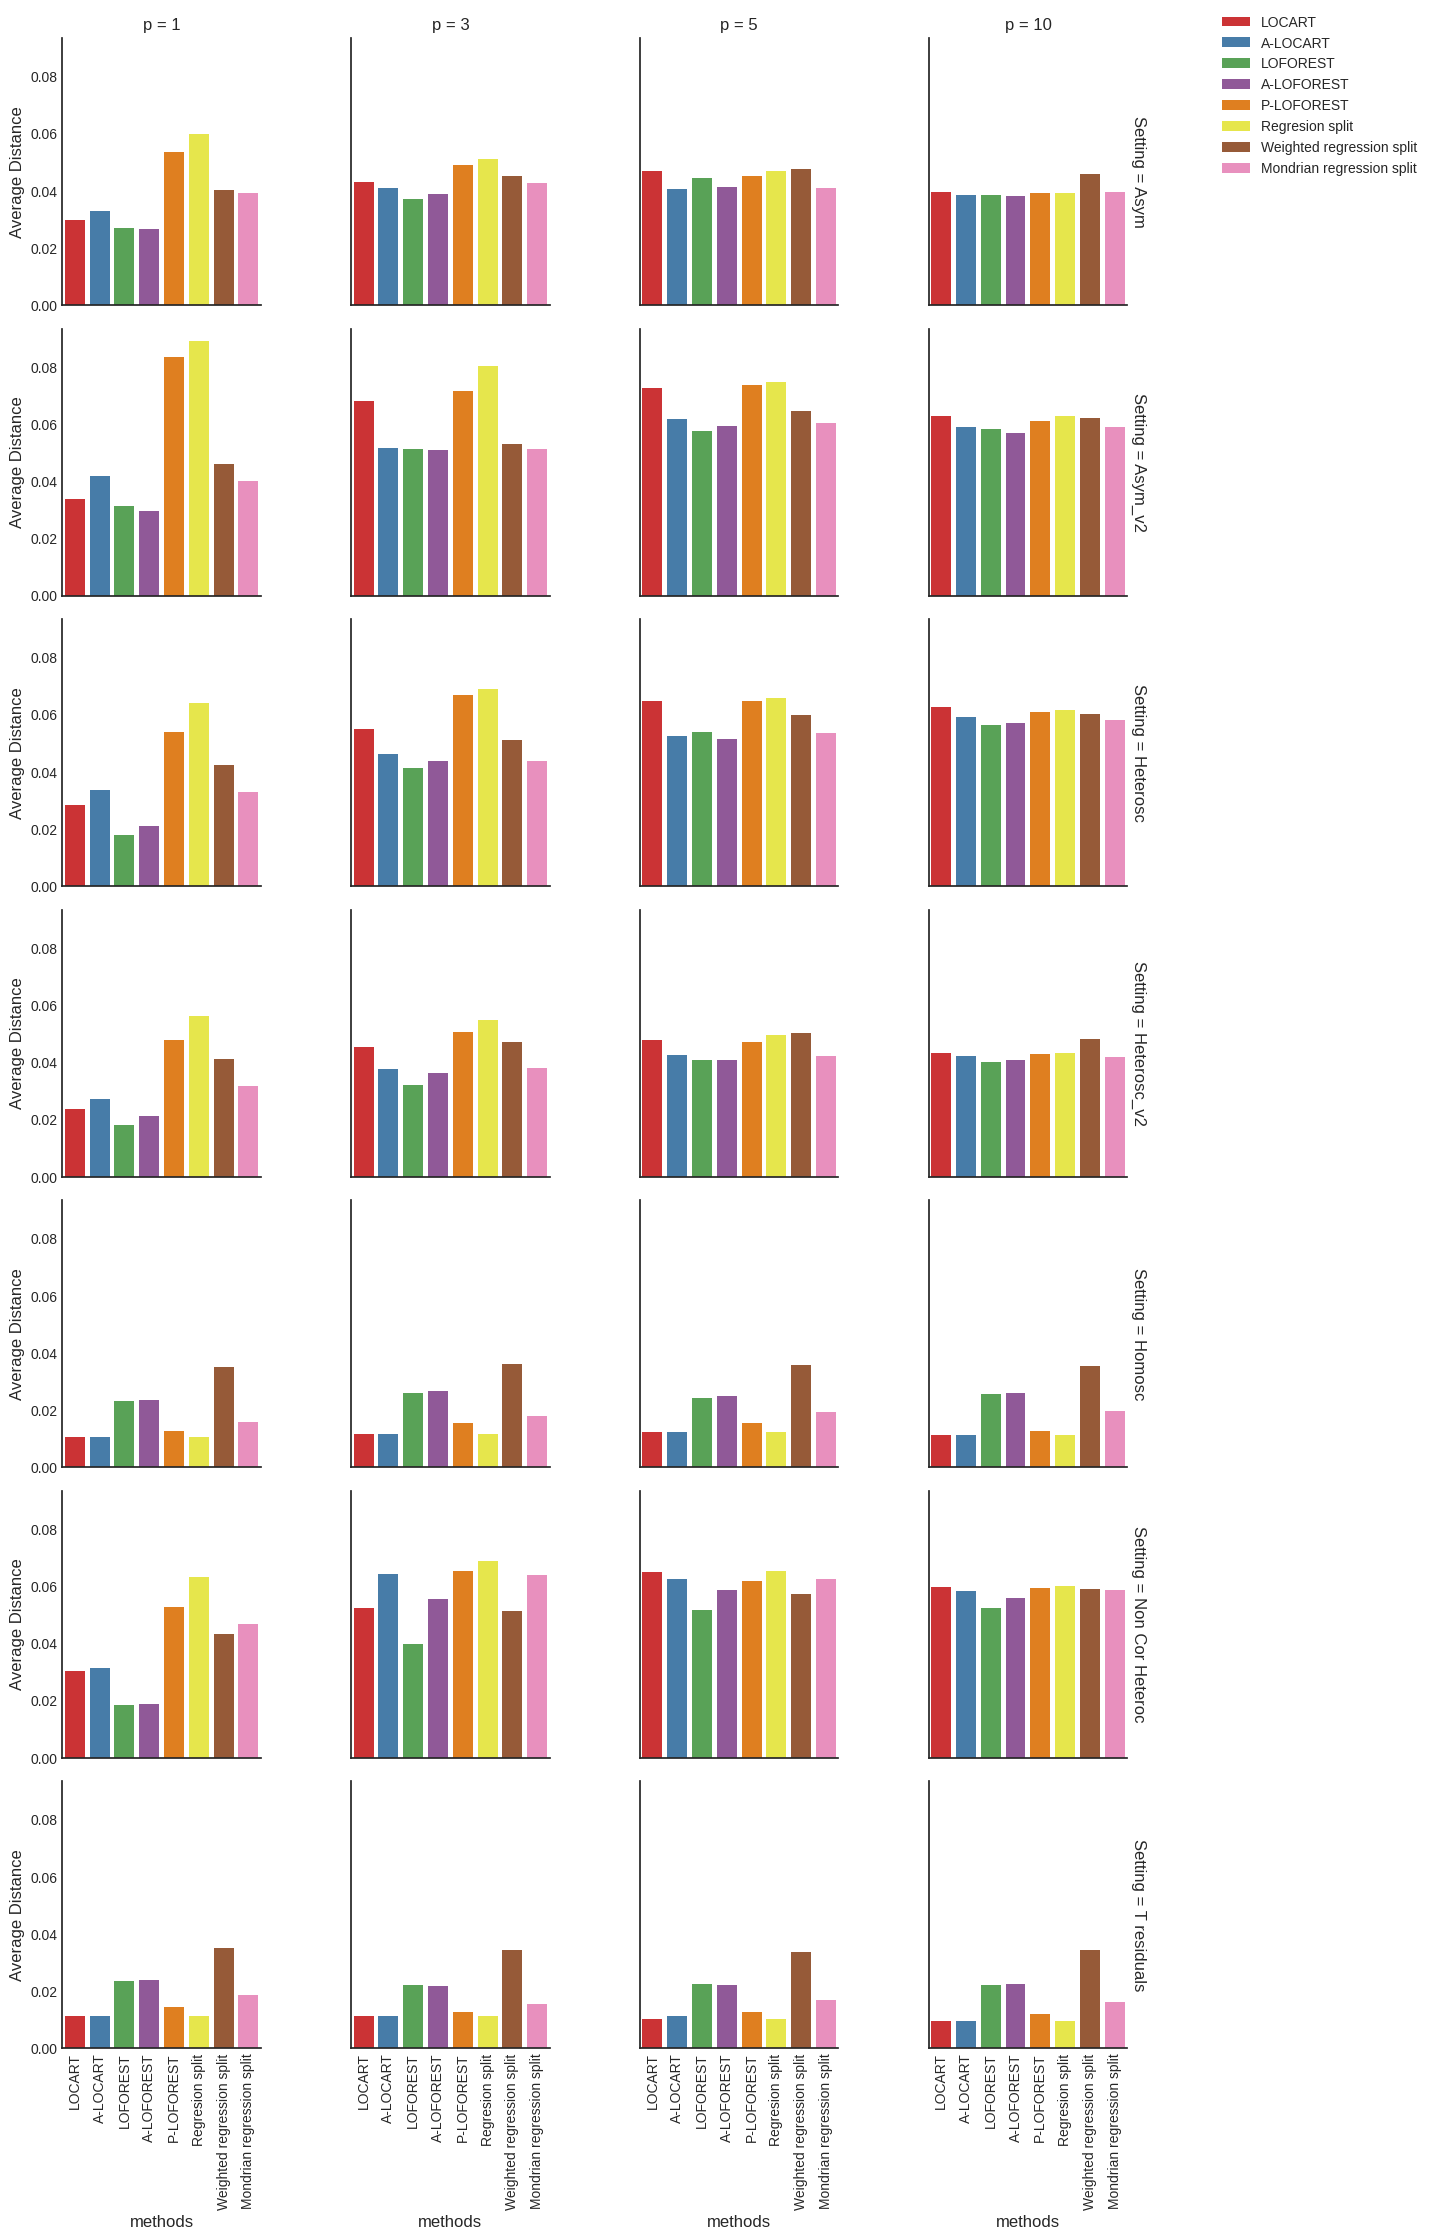

In [119]:
# Assuming melted_df is the DataFrame you want to plot
plt.figure(figsize=(20, 15))  # Adjust the width and height as needed
g = sns.FacetGrid(melted_df, row = "Setting", col = "p", margin_titles=True)
g.map_dataframe(sns.barplot, x = "methods", y = "Average Distance", palette = "Set1", hue = "methods", dodge = False)
g.add_legend(bbox_to_anchor=(0.95, 1), loc='upper center')

# Rotate xlabels for visibility
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(90)

plt.savefig("output.pdf", bbox_inches='tight')  # Save the figure
plt.show()  # Display the figure

## Testing conformal loforest in real data

In [2]:
def obtain_main_metrics_real(
    data_name,
    is_fitted = True,
    figname_tree = "tree",
    base_model = RandomForestRegressor,
    neural_network = False,
    sig = 0.1, 
    test_size = 0.4,
    calib_size = 0.5, 
    random_seed = 1250,
    split_calib = False,
    plot_tree = False,
    nbins = 30,
    criterion = "squared_error",
    max_depth = None,
    max_leaf_nodes = None,
    min_samples_leaf = 100,
    min_impurity_decrease = 0,
    n_estimators = 200,
    K = None,
    prune = True,
    **kwargs):

    # importing data, selecting some rows and then splitting
    data_path = os.path.normpath(os.getcwd() + os.sep + os.pardir) + "/data/processed/" + data_name + ".csv"

    # reading data using pandas
    data = pd.read_csv(data_path)
    y = data["target"].to_numpy()
    X = (data.
    drop("target", axis = 1).
    to_numpy())

    print("Number of samples used for training and calibration: {}".format((1 - test_size)*X.shape[0]))
    print("Number of samples used for testing: {}".format(test_size*X.shape[0]))

    # splitting data into train, calibration and test
    data = split(X, y, test_size, calib_size, calibrate = True, random_seed = random_seed)

    if data_name == "electric":
        mean_y, sd_y = np.mean(data["y_train"]), np.sqrt(np.var(data["y_train"]))
        data["y_train"] = (data["y_train"] - mean_y)/sd_y
        data["y_calib"], data["y_test"] = (data["y_calib"] - mean_y)/sd_y, (data["y_test"] - mean_y)/sd_y

    # setting seed
    np.random.seed(random_seed)

    if is_fitted:
        if neural_network:
            torch.manual_seed(45)
            model = base_model(input_dim = d,**kwargs).fit(data["X_train"], data["y_train"])
        else:
            model = base_model(**kwargs).fit(data["X_train"], data["y_train"])
    else:
        model = base_model
    
    # fitting mondrian regression split
    print("Fitting mondrian regression split")
    start_mondrian_split = time.time()
    micp = MondrianRegressionSplit(model, is_fitted = is_fitted, alpha = sig, k = nbins, **kwargs)
    micp.fit(data["X_train"], data["y_train"])
    micp.calibrate(data["X_calib"], data["y_calib"])

    end_mondrian_split = time.time() - start_mondrian_split
    print("Time Elapsed to fit mondrian regression split: ", end_mondrian_split)

    print("Computing metrics")
    start_mondrian_split = time.time()
    # predictions for empirical metrics
    micp_pred = micp.predict(data["X_test"])

    # smis
    micp_smis = smis(micp_pred, data["y_test"], alpha = sig)
        

    # mean interval length
    micp_interval_len = np.mean(compute_interval_length(micp_pred))


    # marginal coverage
    marg_cover = np.logical_and(data["y_test"] >= micp_pred[:, 0], 
        data["y_test"] <= micp_pred[:, 1]) + 0
    micp_ave_marginal_cov = np.mean(
        marg_cover
    )

    # interval length | coveraqe
    cover_idx = np.where(marg_cover == 1)
    micp_interval_len_cover = np.mean(compute_interval_length(micp_pred[cover_idx]))


    end_mondrian_split = time.time() - start_mondrian_split
    print("Time Elapsed to compute statistics for mondrian regression split: ", end_mondrian_split)


    print("Fitting locart")
    start_loc = time.time()
    # fitting locart
    locart_obj = LocartSplit(nc_score = RegressionScore, base_model = model, is_fitted = is_fitted, 
                             alpha = sig, split_calib = split_calib, **kwargs)
    locart_obj.fit(data["X_train"], data["y_train"])
    locart_obj.calib(data["X_calib"], data["y_calib"], max_depth = max_depth, 
    max_leaf_nodes = max_leaf_nodes, min_samples_leaf = min_samples_leaf, criterion = criterion, prune_tree = prune)
    
    end_loc = time.time() - start_loc
    print("Time Elapsed to fit Locart: ", end_loc)

    print("Computing metrics")
    start_loc = time.time()
    # predictions
    locart_pred = np.array(locart_obj.predict(data["X_test"]))

    # smis
    locart_smis = smis(locart_pred, data["y_test"], alpha = sig)

    # marginal coverage
    marg_cover = np.logical_and(data["y_test"] >= locart_pred[:, 0], 
        data["y_test"] <= locart_pred[:, 1]) + 0
    locart_ave_marginal_cov = np.mean(
        marg_cover
    )

    # mean interval length
    locart_interval_len = np.mean(compute_interval_length(locart_pred))

    # interval length | coveraqe
    cover_idx = np.where(marg_cover == 1)
    locart_interval_len_cover = np.mean(compute_interval_length(locart_pred[cover_idx]))
    end_loc = time.time() - start_loc
    print("Time Elapsed to compute metrics for Locart: ", end_loc)

    # fitting normal difficulty locart
    print("Fitting A-locart to toy example:")
    start_loc = time.time()
    dlocart_obj = LocartSplit(nc_score = RegressionScore, cart_type = "CART", base_model = model, is_fitted = is_fitted,
                               alpha = sig, split_calib = split_calib, 
                              weighting = True, **kwargs)
    dlocart_obj.fit(data["X_train"], data["y_train"])
    dlocart_obj.calib(data["X_calib"], data["y_calib"], max_depth = max_depth, 
    max_leaf_nodes = max_leaf_nodes, min_samples_leaf = min_samples_leaf, criterion = criterion, prune_tree = prune)
    
    end_loc = time.time() - start_loc
    print("Time Elapsed to fit A-Locart: ", end_loc)

    print("Computing metrics")
    start_loc = time.time()
    # predictions
    dlocart_pred = np.array(dlocart_obj.predict(data["X_test"]))

    # smis
    dlocart_smis = smis(dlocart_pred, data["y_test"], alpha = sig)

    # mean interval length
    dlocart_interval_len = np.mean(compute_interval_length(dlocart_pred))

    # marginal coverage
    marg_cover = np.logical_and(data["y_test"] >= dlocart_pred[:, 0], 
        data["y_test"] <= dlocart_pred[:, 1]) + 0
    dlocart_ave_marginal_cov = np.mean(
        marg_cover
    )

    # interval length | coveraqe
    cover_idx = np.where(marg_cover == 1)
    dlocart_interval_len_cover = np.mean(compute_interval_length(dlocart_pred[cover_idx]))

    end_loc = time.time() - start_loc
    print("Time Elapsed to compute metrics for A-Locart: ", end_loc)

    print("Fitting conformal loforest")
    start_loc = time.time()
    # fitting conformal loforest
    loforest_obj = ConformalLoforest(nc_score = RegressionScore, base_model = model, is_fitted = is_fitted, 
                                     alpha = sig, split_calib = split_calib, **kwargs)
    loforest_obj.fit(data["X_train"], data["y_train"])
    loforest_obj.calibrate(data["X_calib"], data["y_calib"], n_estimators = n_estimators, K = K, max_depth = max_depth, 
    max_leaf_nodes = max_leaf_nodes, min_samples_leaf = min_samples_leaf, min_impurity_decrease = min_impurity_decrease,
    criterion = criterion, objective = "mse_based")
    
    end_loc = time.time() - start_loc
    print("Time Elapsed to fit Conformal Loforest: ", end_loc)

    print("Computing metrics")
    start_loc = time.time()
    # predictions
    loforest_pred = np.array(loforest_obj.predict(data["X_test"]))

    # marginal coverage
    marg_cover = np.logical_and(data["y_test"] >= loforest_pred[:, 0], 
        data["y_test"] <= loforest_pred[:, 1]) + 0
    loforest_ave_marginal_cov = np.mean(
        marg_cover
    )

    # smis
    loforest_smis = smis(loforest_pred, data["y_test"], alpha = sig)

    # mean interval length
    loforest_interval_len = np.mean(compute_interval_length(loforest_pred))

    # interval length | coveraqe
    cover_idx = np.where(marg_cover == 1)
    loforest_interval_len_cover = np.mean(compute_interval_length(loforest_pred[cover_idx]))
    end_loc = time.time() - start_loc
    print("Time Elapsed to compute metrics for Locart: ", end_loc)


    print("Fitting conformal A-loforest")
    start_loc = time.time()
    # fitting conformal loforest
    aloforest_obj = ConformalLoforest(nc_score = RegressionScore, base_model = model, is_fitted = is_fitted,
                                       alpha = sig, split_calib = split_calib, weighting = True, **kwargs)
    aloforest_obj.fit(data["X_train"], data["y_train"])
    aloforest_obj.calibrate(data["X_calib"], data["y_calib"], n_estimators = n_estimators, K = K, max_depth = max_depth, 
    max_leaf_nodes = max_leaf_nodes, min_samples_leaf = min_samples_leaf, min_impurity_decrease = min_impurity_decrease,
    criterion = criterion, objective = "mse_based")
    
    end_loc = time.time() - start_loc
    print("Time Elapsed to fit Conformal A-Loforest: ", end_loc)

    print("Computing metrics")
    start_loc = time.time()
    # predictions
    aloforest_pred = np.array(aloforest_obj.predict(data["X_test"]))

    # smis
    aloforest_smis = smis(aloforest_pred, data["y_test"], alpha = sig)

    # marginal coverage
    marg_cover = np.logical_and(data["y_test"] >= aloforest_pred[:, 0], 
        data["y_test"] <= aloforest_pred[:, 1]) + 0
    aloforest_ave_marginal_cov = np.mean(
        marg_cover
    )

    # mean interval length
    aloforest_interval_len = np.mean(compute_interval_length(aloforest_pred))

    # interval length | coveraqe
    cover_idx = np.where(marg_cover == 1)
    aloforest_interval_len_cover = np.mean(compute_interval_length(aloforest_pred[cover_idx]))
    end_loc = time.time() - start_loc
    print("Time Elapsed to compute metrics for A-loforest: ", end_loc)

    print("Fitting conformal Pinball Loforest")
    start_loc = time.time()
    # fitting conformal loforest
    qloforest_obj = ConformalLoforest(nc_score = RegressionScore, base_model = model, is_fitted = is_fitted,
                                       alpha = sig, split_calib = split_calib, **kwargs)
    qloforest_obj.fit(data["X_train"], data["y_train"])
    qloforest_obj.calibrate(data["X_calib"], data["y_calib"], n_estimators = n_estimators, K = K, max_depth = max_depth, 
    max_leaf_nodes = max_leaf_nodes, min_samples_leaf = min_samples_leaf, criterion = criterion, objective = "quantile",
    min_impurity_decrease = min_impurity_decrease)

    end_loc = time.time() - start_loc
    print("Time Elapsed to fit Conformal Pinball Loforest: ", end_loc)

    print("Computing metrics")
    start_loc = time.time()
    # predictions
    qloforest_pred = np.array(qloforest_obj.predict(data["X_test"]))

    # smis
    qloforest_smis = smis(qloforest_pred, data["y_test"], alpha = sig)

    # marginal coverage
    marg_cover = np.logical_and(data["y_test"] >= qloforest_pred[:, 0], 
        data["y_test"] <= qloforest_pred[:, 1]) + 0
    qloforest_ave_marginal_cov = np.mean(
        marg_cover
    )

    # mean interval length
    qloforest_interval_len = np.mean(compute_interval_length(qloforest_pred))

    # interval length | coveraqe
    cover_idx = np.where(marg_cover == 1)
    qloforest_interval_len_cover = np.mean(compute_interval_length(qloforest_pred[cover_idx]))
    end_loc = time.time() - start_loc
    print("Time Elapsed to compute metrics for Quantile Loforest: ", end_loc)

    # fitting default regression split
    print("Fitting regression split")
    start_split = time.time()
    icp = RegressionSplit(base_model = model, alpha = sig, is_fitted = True)
    icp.fit(data["X_train"], data["y_train"])
    icp.calibrate(data["X_calib"], data["y_calib"])

    end_split = time.time() - start_split
    print("Time Elapsed to fit regression split: ", end_split)

    print("Computing metrics")
    start_split = time.time()
    # predictions
    icp_pred = icp.predict(data["X_test"])

    # smis
    icp_smis = smis(icp_pred, data["y_test"], alpha = sig)

    # ICP interval length
    icp_interval_len = np.mean(compute_interval_length(icp_pred))

    # marginal coverage
    marg_cover = np.logical_and(data["y_test"] >= icp_pred[:, 0], 
        data["y_test"] <= icp_pred[:, 1]) + 0
    icp_ave_marginal_cov = np.mean(
        marg_cover
    )

    # interval length | coveraqe
    cover_idx = np.where(marg_cover == 1)
    icp_interval_len_cover = np.mean(compute_interval_length(icp_pred[cover_idx]))

    end_split = time.time() - start_split
    print("Time Elapsed to compute statistics for regression split: ", end_split)

    # fitting wighted regression split
    print("Fitting weighted regression split")
    start_weighted_split = time.time()
    wicp = LocalRegressionSplit(model, is_fitted = is_fitted, alpha = sig, **kwargs)
    wicp.fit(data["X_train"], data["y_train"])
    wicp.calibrate(data["X_calib"], data["y_calib"])

    end_weighted_split = time.time() - start_weighted_split
    print("Time Elapsed to fit weighted regression split: ", end_weighted_split)

    print("Computing metrics")
    start_weighted_split = time.time()
    # predictions
    wicp_pred = wicp.predict(data["X_test"])

    # smis
    wicp_smis = smis(wicp_pred, data["y_test"], alpha = sig)

    # ICP interval length
    wicp_interval_len = np.mean(compute_interval_length(wicp_pred))

    # marginal coverage
    marg_cover = np.logical_and(data["y_test"] >= wicp_pred[:, 0], 
        data["y_test"] <= wicp_pred[:, 1]) + 0
    wicp_ave_marginal_cov = np.mean(
        marg_cover
    )

    # interval length | coveraqe
    cover_idx = np.where(marg_cover == 1)
    wicp_interval_len_cover = np.mean(compute_interval_length(wicp_pred[cover_idx]))
    print("Time Elapsed to compute statistics for weighted regression split: ", end_weighted_split)
    
    all_results =  pd.DataFrame(data = {"Methods":["LOCART", "A-LOCART", "LOFOREST", "A-LOFOREST", "P-LOFOREST",
                                                   "Regresion split", "Weighted regression split", "Mondrian regression split"],
    "Average marginal coverage":[locart_ave_marginal_cov, dlocart_ave_marginal_cov, loforest_ave_marginal_cov, aloforest_ave_marginal_cov, 
                                 qloforest_ave_marginal_cov, icp_ave_marginal_cov, wicp_ave_marginal_cov, micp_ave_marginal_cov],
    "Average interval length":[locart_interval_len, dlocart_interval_len, loforest_interval_len, aloforest_interval_len,
                               qloforest_interval_len, icp_interval_len, wicp_interval_len, micp_interval_len],
    "Average interval length given coverage":[locart_interval_len_cover, dlocart_interval_len_cover, loforest_interval_len_cover, aloforest_interval_len_cover,
                                              qloforest_interval_len_cover, icp_interval_len_cover, wicp_interval_len_cover, micp_interval_len_cover],
    "SMIS values":[locart_smis, dlocart_smis, loforest_smis, aloforest_smis, qloforest_smis, icp_smis, wicp_smis, micp_smis]})
        
    # plotting tree to visualize partitions
    if plot_tree:
        plt.figure(figsize=(25, 20))
        locart_obj.plot_locart()
        plt.savefig(f"{images_dir}/{figname_tree}")
        plt.show()
    
    return all_results

In [3]:
airfoil_metrics = obtain_main_metrics_real("airfoil", 
                                           random_state = 650,
                                           test_size = 0.2,
                                           random_seed = 450,
                                           sig = 0.1,
                                           min_samples_leaf = 50,
                                           K = 50,
                                           n_estimators = 200)

Number of samples used for training and calibration: 1202.4
Number of samples used for testing: 300.6
Fitting mondrian regression split
Time Elapsed to fit mondrian regression split:  0.05048179626464844
Computing metrics
Time Elapsed to compute statistics for mondrian regression split:  0.015414714813232422
Fitting locart
Time Elapsed to fit Locart:  0.014228582382202148
Computing metrics
Time Elapsed to compute metrics for Locart:  0.0073773860931396484
Fitting A-locart to toy example:
Time Elapsed to fit A-Locart:  0.0314793586730957
Computing metrics
Time Elapsed to compute metrics for A-Locart:  0.01453852653503418
Fitting conformal loforest
Time Elapsed to fit Conformal Loforest:  0.1322939395904541
Computing metrics
Time Elapsed to compute metrics for Locart:  0.059297800064086914
Fitting conformal A-loforest
Time Elapsed to fit Conformal A-Loforest:  0.1607215404510498
Computing metrics
Time Elapsed to compute metrics for A-loforest:  0.06774282455444336
Fitting conformal Pinba

In [4]:
airfoil_metrics

,Methods,Average marginal coverage,Average interval length,Average interval length given coverage,SMIS values
0,LOCART,0.906977,7.597258,7.618497,-11.079316
1,A-LOCART,0.880399,7.819355,7.847157,-10.329421
2,LOFOREST,0.910299,7.973439,7.876423,-10.356576
3,A-LOFOREST,0.897010,7.793717,7.687466,-10.556472
4,P-LOFOREST,0.893688,7.978048,7.978048,-11.932766
5,Regresion split,0.893688,7.975800,7.975800,-11.932908
6,Weighted regression split,0.903654,8.019961,8.057554,-10.363496
7,Mondrian regression split,0.920266,8.635380,8.695095,-11.534675


In [24]:
blog_metrics = obtain_main_metrics_real("blog", 
                                        random_state = 650,
                                        test_size = 0.1,
                                        random_seed = 450,
                                        sig = 0.1,
                                        min_samples_leaf = 300,
                                        nbins = 10,
                                        K = 50,
                                        n_estimators = 200)

Number of samples used for training and calibration: 47157.3
Number of samples used for testing: 5239.700000000001
Fitting mondrian regression split
Time Elapsed to fit mondrian regression split:  2.280578136444092
Computing metrics
Time Elapsed to compute statistics for mondrian regression split:  0.2710719108581543
Fitting locart
Time Elapsed to fit Locart:  5.627402305603027
Computing metrics
Time Elapsed to compute metrics for Locart:  0.08019900321960449
Fitting A-locart to toy example:
Time Elapsed to fit A-Locart:  6.98171067237854
Computing metrics
Time Elapsed to compute metrics for A-Locart:  0.2854437828063965
Fitting conformal loforest
Time Elapsed to fit Conformal Loforest:  41.692291259765625
Computing metrics
Time Elapsed to compute metrics for Locart:  20.09917902946472
Fitting conformal A-loforest
Time Elapsed to fit Conformal A-Loforest:  41.11380696296692
Computing metrics
Time Elapsed to compute metrics for A-loforest:  20.39261269569397
Fitting conformal Pinball Lo

In [25]:
blog_metrics

,Methods,Average marginal coverage,Average interval length,Average interval length given coverage,SMIS values
0,LOCART,0.903435,23.985400,24.155524,-41.801633
1,A-LOCART,0.907634,19.532372,19.479334,-36.929442
2,LOFOREST,0.919466,26.124335,26.151095,-43.268128
3,A-LOFOREST,0.916985,19.586215,19.487131,-36.924399
4,P-LOFOREST,0.900191,17.900000,17.900000,-79.724463
5,Regresion split,0.900191,17.900000,17.900000,-79.724463
6,Weighted regression split,0.888931,17.193326,17.287353,-35.534133
7,Mondrian regression split,0.907061,22.299248,22.040283,-48.007415


In [ ]:
cycle_metrics = obtain_main_metrics_real("cycle", 
                                           random_state = 650,
                                           test_size = 0.2,
                                           random_seed = 450,
                                           sig = 0.1,
                                           min_samples_leaf = 150,
                                           K = 50,
                                           n_estimators = 200)

Number of samples used for training and calibration: 7654.400000000001
Number of samples used for testing: 1913.6000000000001
Fitting mondrian regression split
Time Elapsed to fit mondrian regression split:  0.17323064804077148
Computing metrics
Time Elapsed to compute statistics for mondrian regression split:  0.06298637390136719
Fitting locart
Time Elapsed to fit Locart:  0.07743692398071289
Computing metrics
Time Elapsed to compute metrics for Locart:  0.028951406478881836
Fitting A-locart to toy example:
Time Elapsed to fit A-Locart:  0.14908933639526367
Computing metrics
Time Elapsed to compute metrics for A-Locart:  0.05898404121398926
Fitting conformal loforest
Time Elapsed to fit Conformal Loforest:  0.5843372344970703
Computing metrics
Time Elapsed to compute metrics for Locart:  1.3540492057800293
Fitting conformal A-loforest
Time Elapsed to fit Conformal A-Loforest:  0.76535964012146
Computing metrics
Time Elapsed to compute metrics for A-loforest:  1.3078293800354004
Fittin

In [ ]:
cycle_metrics

,Methods,Average marginal coverage,Average interval length,Average interval length given coverage,SMIS values
0,LOCART,0.892372,11.221467,11.218361,-16.967339
1,A-LOCART,0.895507,10.869244,10.862819,-16.592201
2,LOFOREST,0.902299,11.407354,11.382910,-16.617937
3,A-LOFOREST,0.898642,10.961505,10.950002,-16.427986
4,P-LOFOREST,0.896552,11.367100,11.367100,-17.098434
5,Regresion split,0.896552,11.367000,11.367000,-17.098438
6,Weighted regression split,0.897074,11.557264,11.768561,-16.927879
7,Mondrian regression split,0.895507,11.029083,11.072965,-16.718818


In [ ]:
electric_metrics = obtain_main_metrics_real("electric", 
                                           random_state = 650,
                                           test_size = 0.2,
                                           random_seed = 450,
                                           sig = 0.1,
                                           min_samples_leaf = 150,
                                           K = 40,
                                           n_estimators = 200,
                                           min_impurity_decrease = 5*(10**(-5)))

Number of samples used for training and calibration: 8000.0
Number of samples used for testing: 2000.0
Fitting mondrian regression split
Time Elapsed to fit mondrian regression split:  0.1735553741455078
Computing metrics
Time Elapsed to compute statistics for mondrian regression split:  0.06526350975036621
Fitting locart
Time Elapsed to fit Locart:  0.12698698043823242
Computing metrics
Time Elapsed to compute metrics for Locart:  0.029727458953857422
Fitting A-locart to toy example:
Time Elapsed to fit A-Locart:  0.20931291580200195
Computing metrics
Time Elapsed to compute metrics for A-Locart:  0.0624849796295166
Fitting conformal loforest
Time Elapsed to fit Conformal Loforest:  1.5027351379394531
Computing metrics
Time Elapsed to compute metrics for Locart:  1.4148430824279785
Fitting conformal A-loforest
Time Elapsed to fit Conformal A-Loforest:  1.872476577758789
Computing metrics
Time Elapsed to compute metrics for A-loforest:  1.4125690460205078
Fitting conformal Pinball Lofo

In [ ]:
electric_metrics

,Methods,Average marginal coverage,Average interval length,Average interval length given coverage,SMIS values
0,LOCART,0.907,1.104646,1.112784,-1.406275
1,A-LOCART,0.910,1.107047,1.110934,-1.407190
2,LOFOREST,0.907,1.093654,1.094399,-1.354723
3,A-LOFOREST,0.906,1.096009,1.099346,-1.362008
4,P-LOFOREST,0.914,1.113194,1.113188,-1.418720
5,Regresion split,0.914,1.112920,1.112920,-1.418732
6,Weighted regression split,0.919,1.076097,1.078762,-1.307470
7,Mondrian regression split,0.913,1.129015,1.137508,-1.400813


In [ ]:
kernel_metrics = obtain_main_metrics_real("kernel", 
                                           random_state = 650,
                                           test_size = 0.04,
                                           random_seed = 450,
                                           sig = 0.1,
                                           min_samples_leaf = 300,
                                           K = 60,
                                           n_estimators = 200,
                                           min_impurity_decrease = 5*(10**(-5)))

Number of samples used for training and calibration: 231936.0
Number of samples used for testing: 9664.0
Fitting mondrian regression split
Time Elapsed to fit mondrian regression split:  9.768414497375488
Computing metrics
Time Elapsed to compute statistics for mondrian regression split:  0.675912618637085
Fitting locart
Time Elapsed to fit Locart:  15.11044955253601
Computing metrics
Time Elapsed to compute metrics for Locart:  0.3278636932373047
Fitting A-locart to toy example:
Time Elapsed to fit A-Locart:  25.14479351043701
Computing metrics
Time Elapsed to compute metrics for A-Locart:  0.667445182800293
Fitting conformal loforest
Time Elapsed to fit Conformal Loforest:  28.822721242904663
Computing metrics
Time Elapsed to compute metrics for Locart:  170.36904859542847
Fitting conformal A-loforest
Time Elapsed to fit Conformal A-Loforest:  41.72874617576599
Computing metrics
Time Elapsed to compute metrics for A-loforest:  184.6225905418396
Fitting conformal Pinball Loforest


: 

In [ ]:
kernel_metrics

,Methods,Average marginal coverage,Average interval length,Average interval length given coverage,SMIS values
0,LOCART,0.897558,4.016197,4.058201,-6.203396
1,A-LOCART,0.898489,3.736933,3.767957,-5.799637
2,LOFOREST,0.896937,3.920240,3.917047,-6.105833
3,A-LOFOREST,0.899731,3.722245,3.725829,-5.839937
4,P-LOFOREST,0.898282,3.949147,3.949147,-10.080154
5,Regresion split,0.898282,3.949133,3.949133,-10.080154
6,Weighted regression split,0.895281,3.645606,3.668338,-5.340836
7,Mondrian regression split,0.897972,3.877549,3.906437,-6.297112


In [18]:
news_metrics = obtain_main_metrics_real("news", 
                                           random_state = 650,
                                           test_size = 0.2,
                                           random_seed = 450,
                                           sig = 0.1,
                                           min_samples_leaf = 350,
                                           K = 50,
                                           n_estimators = 200,
                                           min_impurity_decrease = 5*(10**(-5)))

Number of samples used for training and calibration: 31715.2
Number of samples used for testing: 7928.8
Fitting mondrian regression split
Time Elapsed to fit mondrian regression split:  0.9915180206298828
Computing metrics
Time Elapsed to compute statistics for mondrian regression split:  0.31522130966186523
Fitting locart
Time Elapsed to fit Locart:  2.0984935760498047
Computing metrics
Time Elapsed to compute metrics for Locart:  0.14469218254089355
Fitting A-locart to toy example:
Time Elapsed to fit A-Locart:  2.492166757583618
Computing metrics
Time Elapsed to compute metrics for A-Locart:  0.3045828342437744
Fitting conformal loforest
Time Elapsed to fit Conformal Loforest:  22.59147357940674
Computing metrics
Time Elapsed to compute metrics for Locart:  20.80610489845276
Fitting conformal A-loforest
Time Elapsed to fit Conformal A-Loforest:  21.811917066574097
Computing metrics
Time Elapsed to compute metrics for A-loforest:  20.705124616622925
Fitting conformal Pinball Loforest

In [19]:
news_metrics

,Methods,Average marginal coverage,Average interval length,Average interval length given coverage,SMIS values
0,LOCART,0.902131,12100.496102,12137.631130,-31034.623790
1,A-LOCART,0.907176,9988.060491,10007.177789,-28230.808556
2,LOFOREST,0.911338,12140.870257,12111.609241,-30323.892236
3,A-LOFOREST,0.907807,9620.677606,9625.926859,-28291.427255
4,P-LOFOREST,0.903771,13277.677821,13277.677821,-33962.345374
5,Regresion split,0.903771,13277.520000,13277.520000,-33962.339422
6,Weighted regression split,0.900114,11260.296311,11571.362991,-27907.014634
7,Mondrian regression split,0.901879,9165.394412,9150.349751,-28403.515329


In [20]:
protein_metrics = obtain_main_metrics_real("protein", 
                                           random_state = 650,
                                           test_size = 0.1,
                                           random_seed = 450,
                                           sig = 0.1,
                                           min_samples_leaf = 350,
                                           K = 50,
                                           n_estimators = 200,
                                           min_impurity_decrease = 5*(10**(-5)))

Number of samples used for training and calibration: 41157.0
Number of samples used for testing: 4573.0
Fitting mondrian regression split
Time Elapsed to fit mondrian regression split:  1.2646689414978027
Computing metrics
Time Elapsed to compute statistics for mondrian regression split:  0.23239469528198242
Fitting locart
Time Elapsed to fit Locart:  1.0729353427886963
Computing metrics
Time Elapsed to compute metrics for Locart:  0.10385751724243164
Fitting A-locart to toy example:
Time Elapsed to fit A-Locart:  1.6056768894195557
Computing metrics
Time Elapsed to compute metrics for A-Locart:  0.20453906059265137
Fitting conformal loforest
Time Elapsed to fit Conformal Loforest:  9.754250764846802
Computing metrics
Time Elapsed to compute metrics for Locart:  15.765824794769287
Fitting conformal A-loforest
Time Elapsed to fit Conformal A-Loforest:  9.39228081703186
Computing metrics
Time Elapsed to compute metrics for A-loforest:  16.738919496536255
Fitting conformal Pinball Lofores

In [21]:
protein_metrics

,Methods,Average marginal coverage,Average interval length,Average interval length given coverage,SMIS values
0,LOCART,0.892193,11.796842,11.854385,-16.893107
1,A-LOCART,0.896785,9.349918,9.394924,-13.857493
2,LOFOREST,0.901159,11.935195,11.903460,-16.577145
3,A-LOFOREST,0.901815,9.468963,9.471031,-13.791705
4,P-LOFOREST,0.904220,12.713786,12.713786,-17.491781
5,Regresion split,0.904220,12.713380,12.713380,-17.491764
6,Weighted regression split,0.899847,9.925078,9.885012,-14.670209
7,Mondrian regression split,0.902471,9.655580,9.668769,-13.959779


In [22]:
superconductivity = obtain_main_metrics_real("superconductivity", 
                                           random_state = 650,
                                           test_size = 0.2,
                                           random_seed = 450,
                                           sig = 0.1,
                                           min_samples_leaf = 300,
                                           K = 50,
                                           n_estimators = 200,
                                           min_impurity_decrease = 5*(10**(-5)))

Number of samples used for training and calibration: 17010.4
Number of samples used for testing: 4252.6
Fitting mondrian regression split
Time Elapsed to fit mondrian regression split:  0.4611635208129883
Computing metrics
Time Elapsed to compute statistics for mondrian regression split:  0.1562201976776123
Fitting locart
Time Elapsed to fit Locart:  0.9838924407958984
Computing metrics
Time Elapsed to compute metrics for Locart:  0.06362295150756836
Fitting A-locart to toy example:
Time Elapsed to fit A-Locart:  1.311232328414917
Computing metrics
Time Elapsed to compute metrics for A-Locart:  0.15942144393920898
Fitting conformal loforest
Time Elapsed to fit Conformal Loforest:  15.872833251953125
Computing metrics
Time Elapsed to compute metrics for Locart:  5.802987337112427
Fitting conformal A-loforest
Time Elapsed to fit Conformal A-Loforest:  17.3304340839386
Computing metrics
Time Elapsed to compute metrics for A-loforest:  5.807073354721069
Fitting conformal Pinball Loforest
T

In [23]:
superconductivity

,Methods,Average marginal coverage,Average interval length,Average interval length given coverage,SMIS values
0,LOCART,0.900541,27.468528,27.404394,-43.800328
1,A-LOCART,0.904773,25.324646,25.112828,-38.327909
2,LOFOREST,0.907595,27.920389,27.773719,-43.012649
3,A-LOFOREST,0.910181,25.151314,24.760592,-38.173202
4,P-LOFOREST,0.901481,32.769008,32.769008,-55.150801
5,Regresion split,0.901481,32.768743,32.768743,-55.150797
6,Weighted regression split,0.902892,29.213295,29.977238,-42.428626
7,Mondrian regression split,0.909476,25.161835,24.809790,-39.702605


In [ ]:
winered = obtain_main_metrics_real("winered", 
                                    random_state = 650,
                                    test_size = 0.3,
                                    random_seed = 450,
                                    sig = 0.1,
                                    min_samples_leaf = 150,
                                    K = 40,
                                    n_estimators = 200,
                                    min_impurity_decrease = 5*(10**(-5)))

Number of samples used for training and calibration: 1119.3
Number of samples used for testing: 479.7
Fitting mondrian regression split
Time Elapsed to fit mondrian regression split:  0.03134727478027344
Computing metrics
Time Elapsed to compute statistics for mondrian regression split:  0.015001773834228516
Fitting locart
Time Elapsed to fit Locart:  0.008901119232177734
Computing metrics
Time Elapsed to compute metrics for Locart:  0.006172657012939453
Fitting A-locart to toy example:
Time Elapsed to fit A-Locart:  0.020838022232055664
Computing metrics
Time Elapsed to compute metrics for A-Locart:  0.014906883239746094
Fitting conformal loforest
Time Elapsed to fit Conformal Loforest:  0.1350243091583252
Computing metrics
Time Elapsed to compute metrics for Locart:  0.08196830749511719
Fitting conformal A-loforest
Time Elapsed to fit Conformal A-Loforest:  0.1504671573638916
Computing metrics
Time Elapsed to compute metrics for A-loforest:  0.09137582778930664
Fitting conformal Pinb

In [ ]:
winered

,Methods,Average marginal coverage,Average interval length,Average interval length given coverage,SMIS values
0,LOCART,0.922917,2.153581,2.156269,-2.667923
1,A-LOCART,0.918750,2.095379,2.100990,-2.662772
2,LOFOREST,0.927083,2.152091,2.150857,-2.664749
3,A-LOFOREST,0.920833,2.109951,2.114377,-2.669494
4,P-LOFOREST,0.922917,2.200000,2.200000,-2.697500
5,Regresion split,0.922917,2.200000,2.200000,-2.697500
6,Weighted regression split,0.900000,2.093509,2.123759,-2.821835
7,Mondrian regression split,0.945833,2.462898,2.483160,-2.850883


In [ ]:
winewhite = obtain_main_metrics_real("winewhite", 
                                    random_state = 650,
                                    test_size = 0.2,
                                    random_seed = 450,
                                    sig = 0.1,
                                    min_samples_leaf = 150,
                                    K = 40,
                                    n_estimators = 200,
                                    min_impurity_decrease = 5*(10**(-5)))

Number of samples used for training and calibration: 3918.4
Number of samples used for testing: 979.6
Fitting mondrian regression split
Time Elapsed to fit mondrian regression split:  0.0649266242980957
Computing metrics
Time Elapsed to compute statistics for mondrian regression split:  0.02561473846435547
Fitting locart
Time Elapsed to fit Locart:  0.03211688995361328
Computing metrics
Time Elapsed to compute metrics for Locart:  0.012002944946289062
Fitting A-locart to toy example:
Time Elapsed to fit A-Locart:  0.06060218811035156
Computing metrics
Time Elapsed to compute metrics for A-Locart:  0.025078773498535156
Fitting conformal loforest
Time Elapsed to fit Conformal Loforest:  0.3431117534637451
Computing metrics
Time Elapsed to compute metrics for Locart:  0.35387635231018066
Fitting conformal A-loforest
Time Elapsed to fit Conformal A-Loforest:  0.4236271381378174
Computing metrics
Time Elapsed to compute metrics for A-loforest:  0.36522388458251953
Fitting conformal Pinball 

In [ ]:
winewhite

,Methods,Average marginal coverage,Average interval length,Average interval length given coverage,SMIS values
0,LOCART,0.891837,2.219316,2.225420,-2.995103
1,A-LOCART,0.882653,2.072709,2.098244,-3.034201
2,LOFOREST,0.893878,2.202971,2.208990,-2.993007
3,A-LOFOREST,0.893878,2.215988,2.233163,-3.000099
4,P-LOFOREST,0.893878,2.160000,2.160000,-3.059388
5,Regresion split,0.893878,2.160000,2.160000,-3.059388
6,Weighted regression split,0.894898,2.280456,2.323463,-3.172393
7,Mondrian regression split,0.904082,2.370779,2.397712,-3.087816


## Also testing a CNN model in the simulation and real data settings:

In [3]:
torch.manual_seed(45)
class Net(nn.Module):
    def __init__(self, input_dim, first_l = 20, second_l = 20, third_l = 4, random_state = 650):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_dim, first_l)  # input layer to first hidden layer
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(first_l, second_l)  # first hidden layer to second hidden layer
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(second_l, third_l)  # second hidden layer to third hidden layer
        self.dropout3 = nn.Dropout(0.25)
        self.fc4 = nn.Linear(third_l, 1)
        self.random_numpy = random_state

        # Initialize weights
        self.init_weights()

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                gain = nn.init.calculate_gain("relu")
                nn.init.xavier_normal_(m.weight, gain=gain)

    def plot_history(self):
        plt.plot(self.epoch_list, self.loss_history_train, color="tab:red", label = "training loss")
        plt.plot(self.epoch_list, self.loss_history_validation, color="tab:blue", label = "validation loss")
        plt.legend()
        plt.xlabel("Epoch")
        plt.ylabel("Loss")

    def forward(self, x):
        x = F.selu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))  # activation function for second hidden layer
        x = self.dropout2(x)
        x = F.relu(self.fc3(x))
        x = self.dropout3(x)
        x = self.fc4(x)
        return x

    def predict(self, x):
        # first scaling
        x = self.scaler.transform(x)
        x = torch.tensor(x, dtype = torch.float32)
        with torch.no_grad():
            return self.forward(x).numpy().reshape(-1)

    def fit(self, x_train, y_train, val_size = 0.3, epochs = 1000, batch_size = 150, lr = 0.005, patience = 30):
        # scaling data
        self.scaler = StandardScaler()
        x_train = self.scaler.fit_transform(x_train)

        # splitting into training and validation sets
        x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = val_size, 
                                                          random_state = self.random_numpy)
        
        # encoding data into torch tensor
        x_train, x_val = torch.tensor(x_train, dtype = torch.float32), torch.tensor(x_val, dtype = torch.float32)
        y_train, y_val = torch.tensor(y_train, dtype = torch.float32).view(-1, 1), torch.tensor(y_val, dtype = torch.float32).view(-1, 1)

        # Create Tensor datasets
        train_data = TensorDataset(x_train, y_train)
        val_data = TensorDataset(x_val, y_val)
        
        criterion = nn.MSELoss()
        optimizer = optim.Adamax(self.parameters(), lr=lr)

        # Early stopping initialization
        best_loss = np.inf
        counter = 0

        # tracking loss and epochs
        self.loss_history_validation = []
        self.loss_history_train = []
        self.epoch_list = []
        self.best_loss_history_val = []

        # Create DataLoaders
        train_loader = DataLoader(train_data, shuffle=True, batch_size = batch_size)
        val_loader = DataLoader(val_data, shuffle=True, batch_size = batch_size)

        for epoch in range(epochs):  # number of epochs
            with torch.set_grad_enabled(True):
                loss_vals_train = []
                for inputs, labels in train_loader:
                    inputs.requires_grad_(True)

                    optimizer.zero_grad()
                    outputs = self(inputs)

                    loss = criterion(outputs, labels)
                    loss_vals_train.append(loss.data.item())

                    loss.backward()
                    optimizer.step()

                avgloss_train = np.average(loss_vals_train)
                self.loss_history_train.append(avgloss_train)

            # Validation step
            loss_vals = []
            with torch.no_grad():
                for inputs, labels in val_loader:
                    val_outputs = self(inputs)
                    val_loss = criterion(val_outputs, labels)
                    loss_vals.append(val_loss.data.item())

            avgloss_valid = np.average(loss_vals)
            self.loss_history_validation.append(avgloss_valid)

            self.epoch_list.append(epoch)
            # Early stopping
            if avgloss_valid < best_loss:
                best_loss = avgloss_valid
                self.best_loss_history_val.append(best_loss)
                counter = 0
            else:
                counter += 1
                if counter >= patience:
                    print(f"Early stopping at epoch {epoch}")
                    break

        print(f'Final loss: {avgloss_valid}')
        return self


# testing model
sim_obj = simulation(dim = 20, coef = 2, hetero_value = 0.25, noise = False, signif_vars = 3)
sim_obj.heteroscedastic(5000)
base_model = Net(input_dim = sim_obj.X.shape[1], first_l = 40, second_l = 40, third_l = 10)
base_model.fit(sim_obj.X, sim_obj.y, batch_size = 150, patience = 30)

Early stopping at epoch 148
Final loss: 1.2823134303092956


Net(
  (fc1): Linear(in_features=20, out_features=40, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=40, out_features=40, bias=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=40, out_features=10, bias=True)
  (dropout3): Dropout(p=0.25, inplace=False)
  (fc4): Linear(in_features=10, out_features=1, bias=True)
)

Testing the model in the heteroscedastic setting:

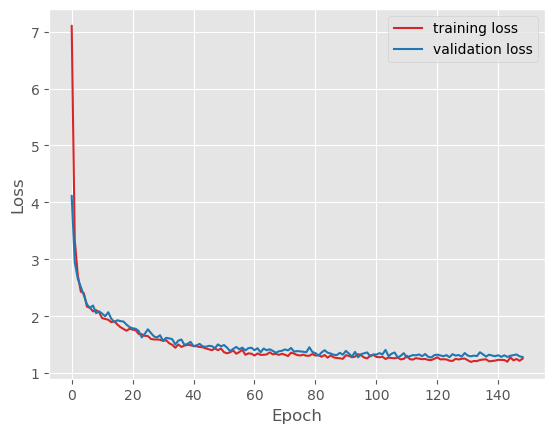

In [144]:
base_model.plot_history()

In [132]:
# loss in a separate test set
sim_obj.heteroscedastic(2000)
preds = base_model.predict(sim_obj.X)
np.average((preds - sim_obj.y)**2)

1.2445192855540532

## Simulations using the CNN base model

### Homoscedastic data

In [4]:
# all dictionaries to store the results
homosc_metrics_dict, heterosc_metrics_dict, asym_metrics_dict, t_metrics_dict, non_cor_heteroc_dict = {}, {}, {}, {}, {}

In [5]:
# Homoscedastic
for p in tqdm([1, 3, 5, 10], desc="Homoscedastic"):
    print(f"Testing homoscedastic scenario with p={p}")
    if(p == 1):
        noise = True
    else:
        noise = False
    homosc_metrics_dict[str(p)] = obtain_main_metrics_sim(signif_vars = p, 
                                                          kind="homoscedastic",
                                                          base_model = Net, 
                                                          is_fitted = True,
                                                          neural_network = True,
                                                          noise = noise, random_seed = 950, 
                                                          n_estimators = 200, 
                                                          min_samples_leaf = 300, 
                                                          K = 40, 
                                                          min_impurity_decrease = 5*(10**(-5)),
                                                          first_l = 40, 
                                                          second_l = 40, 
                                                          third_l = 10,
                                                          random_state = 650)

Homoscedastic:   0%|          | 0/4 [00:00<?, ?it/s]

Testing homoscedastic scenario with p=1
Early stopping at epoch 179
Final loss: 1.3504829704761505
Fitting mondrian regression split
Time Elapsed to fit mondrian regression split:  12.241401195526123
Computing metrics
Time Elapsed to compute statistics for mondrian regression split:  0.23843598365783691
Fitting locart
Time Elapsed to fit Locart:  0.4120042324066162
Computing metrics
Time Elapsed to compute metrics for Locart:  0.04221391677856445
Fitting A-locart to toy example:
Time Elapsed to fit A-Locart:  12.438520431518555
Computing metrics
Time Elapsed to compute metrics for A-Locart:  0.22478842735290527
Fitting conformal loforest
Time Elapsed to fit Conformal Loforest:  9.308105230331421
Computing metrics
Time Elapsed to compute metrics for Locart:  16.27980089187622
Fitting conformal A-loforest
Time Elapsed to fit Conformal A-Loforest:  21.662793397903442
Computing metrics
Time Elapsed to compute metrics for A-loforest:  16.394869804382324
Fitting conformal Pinball Loforest
Ti

Homoscedastic:  25%|██▌       | 1/4 [02:11<06:33, 131.20s/it]

Early stopping at epoch 67
Final loss: 0.4811206191778183
Time Elapsed to fit weighted regression split:  5.268617868423462
Computing metrics
Time Elapsed to compute statistics for weighted regression split:  5.268617868423462
Testing homoscedastic scenario with p=3
Early stopping at epoch 169
Final loss: 1.1438443690538407
Fitting mondrian regression split
Time Elapsed to fit mondrian regression split:  11.0541250705719
Computing metrics
Time Elapsed to compute statistics for mondrian regression split:  0.24798226356506348
Fitting locart
Time Elapsed to fit Locart:  0.37206292152404785
Computing metrics
Time Elapsed to compute metrics for Locart:  0.03940749168395996
Fitting A-locart to toy example:
Time Elapsed to fit A-Locart:  11.292117834091187
Computing metrics
Time Elapsed to compute metrics for A-Locart:  0.2304093837738037
Fitting conformal loforest
Time Elapsed to fit Conformal Loforest:  8.980555772781372
Computing metrics
Time Elapsed to compute metrics for Locart:  17.0095

Homoscedastic:  50%|█████     | 2/4 [04:15<04:14, 127.28s/it]

Early stopping at epoch 65
Final loss: 0.4214330792427063
Time Elapsed to fit weighted regression split:  5.266091823577881
Computing metrics
Time Elapsed to compute statistics for weighted regression split:  5.266091823577881
Testing homoscedastic scenario with p=5
Early stopping at epoch 113
Final loss: 1.112465927004814
Fitting mondrian regression split
Time Elapsed to fit mondrian regression split:  10.636735439300537
Computing metrics
Time Elapsed to compute statistics for mondrian regression split:  0.22814059257507324
Fitting locart
Time Elapsed to fit Locart:  0.5196425914764404
Computing metrics
Time Elapsed to compute metrics for Locart:  0.039602041244506836
Fitting A-locart to toy example:
Time Elapsed to fit A-Locart:  11.12266230583191
Computing metrics
Time Elapsed to compute metrics for A-Locart:  0.21410655975341797
Fitting conformal loforest
Time Elapsed to fit Conformal Loforest:  9.292081356048584
Computing metrics
Time Elapsed to compute metrics for Locart:  16.537

Homoscedastic:  75%|███████▌  | 3/4 [06:15<02:03, 123.81s/it]

Early stopping at epoch 66
Final loss: 0.3995606765151024
Time Elapsed to fit weighted regression split:  4.910665512084961
Computing metrics
Time Elapsed to compute statistics for weighted regression split:  4.910665512084961
Testing homoscedastic scenario with p=10
Early stopping at epoch 132
Final loss: 1.0719088733196258
Fitting mondrian regression split
Time Elapsed to fit mondrian regression split:  11.182425260543823
Computing metrics
Time Elapsed to compute statistics for mondrian regression split:  0.24056529998779297
Fitting locart
Time Elapsed to fit Locart:  0.39442992210388184
Computing metrics
Time Elapsed to compute metrics for Locart:  0.040879249572753906
Fitting A-locart to toy example:
Time Elapsed to fit A-Locart:  11.384567499160767
Computing metrics
Time Elapsed to compute metrics for A-Locart:  0.21352243423461914
Fitting conformal loforest
Time Elapsed to fit Conformal Loforest:  9.235821008682251
Computing metrics
Time Elapsed to compute metrics for Locart:  17

Homoscedastic: 100%|██████████| 4/4 [08:17<00:00, 124.50s/it]

Early stopping at epoch 71
Final loss: 0.3811867222189903
Time Elapsed to fit weighted regression split:  5.676576375961304
Computing metrics
Time Elapsed to compute statistics for weighted regression split:  5.676576375961304


In [6]:
homosc_metrics_dict["1"]

,Methods,Average marginal coverage,Average interval length,Average interval length given coverage,Average distance,Median distance,Max distance
0,LOCART,0.9086,3.839046,3.841115,0.040379,0.028,0.593
1,A-LOCART,0.8970,3.772812,3.775416,0.039022,0.026,0.596
2,LOFOREST,0.9000,3.793497,3.800529,0.042929,0.031,0.585
3,A-LOFOREST,0.9112,3.824435,3.831116,0.041244,0.031,0.596
4,P-LOFOREST,0.9050,3.810206,3.808632,0.046011,0.034,0.639
5,Regresion split,0.9052,3.822925,3.822925,0.048155,0.036,0.717
6,Weighted regression split,0.8982,3.813868,3.820985,0.044332,0.030,0.714
7,Mondrian regression split,0.8956,3.810887,3.815449,0.049003,0.036,0.635


In [7]:
homosc_metrics_dict["3"]

,Methods,Average marginal coverage,Average interval length,Average interval length given coverage,Average distance,Median distance,Max distance
0,LOCART,0.9044,3.539256,3.539256,0.027070,0.0190,0.636
1,A-LOCART,0.9076,3.548082,3.548082,0.026560,0.0190,0.544
2,LOFOREST,0.9102,3.579402,3.583963,0.031313,0.0255,0.586
3,A-LOFOREST,0.9060,3.564516,3.573196,0.034039,0.0270,0.666
4,P-LOFOREST,0.9024,3.511522,3.511602,0.025596,0.0170,0.597
5,Regresion split,0.9022,3.510202,3.510202,0.025688,0.0170,0.618
6,Weighted regression split,0.9026,3.534202,3.536183,0.025929,0.0165,0.499
7,Mondrian regression split,0.9078,3.544510,3.546975,0.029188,0.0200,0.753


In [8]:
homosc_metrics_dict["5"]

,Methods,Average marginal coverage,Average interval length,Average interval length given coverage,Average distance,Median distance,Max distance
0,LOCART,0.9068,3.477774,3.477774,0.021480,0.015,0.541
1,A-LOCART,0.9060,3.449191,3.449191,0.021123,0.014,0.557
2,LOFOREST,0.9070,3.524599,3.532191,0.031548,0.026,0.638
3,A-LOFOREST,0.9054,3.518241,3.524921,0.031111,0.026,0.609
4,P-LOFOREST,0.9012,3.446874,3.447480,0.021466,0.014,0.468
5,Regresion split,0.9018,3.443532,3.443533,0.020727,0.013,0.538
6,Weighted regression split,0.9098,3.467145,3.470380,0.021764,0.014,0.475
7,Mondrian regression split,0.9058,3.503001,3.506533,0.026631,0.019,0.472


In [9]:
homosc_metrics_dict["10"]

,Methods,Average marginal coverage,Average interval length,Average interval length given coverage,Average distance,Median distance,Max distance
0,LOCART,0.9058,3.401836,3.401836,0.014735,0.010,0.322
1,A-LOCART,0.9120,3.423313,3.423313,0.015052,0.011,0.428
2,LOFOREST,0.9070,3.427693,3.433192,0.025933,0.022,0.247
3,A-LOFOREST,0.9072,3.424795,3.431538,0.026768,0.022,0.389
4,P-LOFOREST,0.9042,3.398105,3.398395,0.015946,0.011,0.363
5,Regresion split,0.9046,3.392843,3.392843,0.014450,0.010,0.312
6,Weighted regression split,0.9018,3.369694,3.371528,0.016255,0.011,0.305
7,Mondrian regression split,0.9050,3.444164,3.445785,0.020405,0.017,0.381


### Heteroscedastic data

In [ ]:
# Heteroscedastic
for p in tqdm([1, 3, 5, 10], desc="Heteroscedastic"):
    if(p == 1):
        noise = True
    else:
        noise = False
    for hetero_value in [0.25, 0.6]:
        print(f"Testing heteroscedastic scenario with p={p} and hetero_value={hetero_value}")
        heterosc_metrics_dict[f"{p}_{hetero_value}"] = obtain_main_metrics_sim(signif_vars = p, kind="heteroscedastic", 
                                                                    hetero_value=hetero_value, noise = noise, random_seed = 950, random_state = 650,
                                                                     n_estimators = 200, min_samples_leaf = 300, K = 40, min_impurity_decrease = 5*(10**(-5)))

In [ ]:
heterosc_metrics_dict["5_0.25"]

In [ ]:
heterosc_metrics_dict["5_0.6"]

In [ ]:
heterosc_metrics_dict["3_0.25"]

In [ ]:
heterosc_metrics_dict["3_0.6"]

In [ ]:
heterosc_metrics_dict["10_0.25"]

In [ ]:
heterosc_metrics_dict["10_0.6"]

In [ ]:
heterosc_metrics_dict["1_0.25"]

In [ ]:
heterosc_metrics_dict["1_0.6"]

### Assymetric data

In [ ]:
# Assymetric
for p in tqdm([1, 3, 5, 10], desc="Assymetric"):
    if(p == 1):
        noise = True
    else:
        noise = False 
    for asym_value in [0.6, 1.5]:
        print(f"Testing assymetric scenario with p={p} and asym_value={asym_value}")
        asym_metrics_dict[f"{p}_{asym_value}"] = obtain_main_metrics_sim(signif_vars=p, kind="asymmetric", 
                                                                         asym_value=asym_value, noise = noise, random_seed = 950, random_state = 650,
                                                                         n_estimators = 200, min_samples_leaf = 300, K = 40, min_impurity_decrease = 5*(10**(-5)))

In [ ]:
asym_metrics_dict["1_0.6"]

In [ ]:
asym_metrics_dict["1_1.5"]

In [ ]:
asym_metrics_dict["3_0.6"]

In [ ]:
asym_metrics_dict["3_1.5"]

In [ ]:
asym_metrics_dict["5_0.6"]

In [ ]:
asym_metrics_dict["5_1.5"]

In [ ]:
asym_metrics_dict["10_0.6"]

In [ ]:
asym_metrics_dict["10_1.5"]

### T-residuals

In [ ]:
# T-residuals
for p in tqdm([1, 3, 5, 10], desc="T-residuals"):
    if(p == 1):
        noise = True
    else:
        noise = False
    print(f"Testing t-residuals scenario with p={p} and t_degree=4")
    t_metrics_dict[str(p)] = obtain_main_metrics_sim(signif_vars=p, kind="t_residuals", 
                                                     t_degree=4, noise = noise, random_seed = 950, random_state = 650,
                                                     n_estimators = 200, min_samples_leaf = 300, K = 40, min_impurity_decrease = 5*(10**(-5)))

In [ ]:
t_metrics_dict["1"]

In [ ]:
t_metrics_dict["3"]

In [ ]:
t_metrics_dict["5"]

In [ ]:
t_metrics_dict["10"]

### Non-correlated heteroscedastic data

In [ ]:
# Non_cor_heteroscedastic
for p in tqdm([1, 3, 5, 10], desc="Non_cor_heteroscedastic"):
    if(p == 1):
        noise = True
    else:
        noise = False
    print(f"Testing non_cor_heteroscedastic scenario with p={p} and hetero_value=0.25")
    non_cor_heteroc_dict[str(p)] = obtain_main_metrics_sim(signif_vars=p, kind="non_cor_heteroscedastic", 
                                                           hetero_value=0.25, noise = noise, random_seed = 950, random_state = 650,
                                                           n_estimators = 200, min_samples_leaf = 300, K = 40, min_impurity_decrease = 5*(10**(-5)))

In [ ]:
non_cor_heteroc_dict["1"]

In [ ]:
non_cor_heteroc_dict["3"]

In [ ]:
non_cor_heteroc_dict["5"]

In [ ]:
non_cor_heteroc_dict["10"]

### Plotting all results:

In [ ]:
# combining all data
combined_df = pd.concat(dataframes_list)

# melting the simulation settings columns
melted_df = pd.melt(combined_df, id_vars=['p', 'methods'], 
                    value_vars=['Asym', 'Asym_v2', 'Heterosc', 'Heterosc_v2', 'Homosc', 'Non Cor Heteroc', 'T residuals'], 
                    var_name = 'Setting',
                    value_name = 'Average Distance')

melted_df.head(10)
# Assuming melted_df is the DataFrame you want to plot
plt.figure(figsize=(20, 15))  # Adjust the width and height as needed
g = sns.FacetGrid(melted_df, row = "Setting", col = "p", margin_titles=True)
g.map_dataframe(sns.barplot, x = "methods", y = "Average Distance", palette = "Set1", hue = "methods", dodge = False)
g.add_legend(bbox_to_anchor=(0.95, 1), loc='upper center')

# Rotate xlabels for visibility
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(90)

plt.savefig("output.pdf", bbox_inches='tight')  # Save the figure
plt.show()  # Display the figure

## Real data experiments with CNN model: